**Graduation Project :  Personalized Education Platform Powered by AI- Chatbot for Adaptive Learning**

**Team 1** - Sprints Bootcamp

**Team Members:**
  * Menna Mohamed
  * Dina Fakhry
  * Abanoub Younan
  * Karen Emad
  * Basel Amr
  * Ahmed Hesham
  * Omar Tarek

**Date: 2024-03-24**

**Table of Content**

# 🚀 **2. Setting Up the Environment**

## **2.1 Connect to google colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change directory
import os
os.chdir('/content/drive/MyDrive/Sprints task/Graduation Project')

## 2.2 Import Necessary libraries

In [ ]:
# 🔹 Standard Library Imports
import os
import re
import shutil
import sqlite3
import string
import time
import random
import warnings
from datetime import datetime, timedelta

# 🔹 Data Science & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import graphviz

# 🔹 CLI & Table Formatting
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.theme import Theme
from rich.box import SIMPLE  # ✅ Clean table box style
from rich import box
from tabulate import tabulate
from prettytable import PrettyTable
from rich.table import Table as RichTable

# 🔹 Initialize Rich Console
console = Console()

In [ ]:
# to get packages initially installed in colab or in other word, the colab environment
!pip3 freeze > requirements.txt

# 📌 **3. Task 1 : Set Up the Relational Database with SQLite**
**Description**: You will create and set up a SQLite database file to store structured data for books, authors, and user information. SQLite is a file-based database that does not require a separate server

**Requirments**:
-  Install SQLite and ensure it is accessible from your command line or terminal.
- Create a new SQLite database file (e.g., bookbazaar.db).
- Ensure that your application or Python scripts will have permission to read and write to this database file

**Responsible:** Abanoub Younan

In [ ]:
# Create a new SQLite database file called bookbazaar.db
DB_NAME = 'CourseDataBase.db'

# Ensure that our application will have the permission to read and write the database
if os.path.exists(DB_NAME):
    os.remove(DB_NAME)
    print("✅ Database succesfully deleted.")

db_conn = sqlite3.connect(DB_NAME)
db_conn.execute("PRAGMA journal_mode=WAL;")
cursor = db_conn.cursor()
print("✅ Database connection established.")

✅ Database connection established.


In [ ]:
def execute_sql(query: str, table_name: str, db_conn):
    """
    Executes an SQL query, handles errors, and displays the table structure beautifully.

    Parameters:
        query (str): The SQL query to execute.
        table_name (str): The name of the table affected.
        db_conn (sqlite3.Connection): Active SQLite database connection.
    """
    try:
        console.print(f"\n[cyan]⏳ Executing query for table: [bold]{table_name}[/bold]...[/cyan]", style="bold cyan")

        cursor = db_conn.cursor()
        cursor.execute(query)
        db_conn.commit()

        console.print(f"✅ [green]Success! Table '{table_name}' created or updated.[/green]", style="bold green")

        # Fetch table structure
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()

        if not columns:
            console.print(f"[red]❌ No table structure found for '{table_name}'![/red]", style="bold red")
            return

        # Display table structure using PrettyTable
        table = PrettyTable(["Column ID", "Column Name", "Data Type", "Not Null", "Default Value", "Primary Key"])
        for col in columns:
            table.add_row([col[0], col[1], col[2], col[3], col[4] or "NULL", col[5]])

        console.print("\n[bold yellow]📌 Table Structure:[/bold yellow]")
        console.print(table)

    except sqlite3.Error as e:
        console.print(f"\n[red]❌ SQL Execution Failed![/red] Error: {e}", style="bold red")

    except Exception as e:
        console.print(f"\n[magenta]⚠️ Unexpected error: {e}[/magenta]", style="bold magenta")

    finally:
        cursor.close()
        console.print("[blue]🔍 Query execution complete.[/blue]", style="bold blue")

In [ ]:
def delete_table(table_name, db_conn):
    """
    Deletes a table from the database with confirmation, error handling, and detailed output.

    Args:
        table_name (str): The name of the table to be deleted.
        db_conn (sqlite3.Connection): The SQLite database connection.
    """
    try:
        cursor = db_conn.cursor()

        # Step 1: Confirm Deletion
        console.print(f"[bold yellow]⚠ WARNING:[/] You are about to delete the table [bold red]{table_name}[/].")
        confirmation = input("Are you sure? Type 'YES' to confirm: ")
        if confirmation.strip().upper() != "YES":
            console.print("[bold red]❌ Deletion canceled![/]")
            return

        start_time = time.time()

        # Step 2: Drop the table
        cursor.execute(f"DROP TABLE IF EXISTS {table_name};")
        db_conn.commit()

        end_time = time.time()
        execution_time = end_time - start_time

        console.print(f"[bold green]✅ Successfully deleted the table '{table_name}' in {execution_time:.4f} seconds![/]")

        # Step 3: Display Remaining Tables
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()

        if tables:
            table = Table(title="📌 Remaining Tables in Database")
            table.add_column("Table Name", justify="left", style="cyan", no_wrap=True)
            for tbl in tables:
                table.add_row(tbl[0])
            console.print(table)
        else:
            console.print("[bold yellow]⚠ No tables left in the database![/]")

    except sqlite3.Error as e:
        console.print(f"[bold red]❌ SQL Execution Failed![/] Error: {e}")

    finally:
        cursor.close()

In [ ]:
delete_table("submissions",db_conn)

⚠ WARNING: You are about to delete the table submissions.

Are you sure? Type 'YES' to confirm: yes


✅ Successfully deleted the table 'submissions' in 2.9468 seconds!

📌 Remaining Tables
    in Database    
┏━━━━━━━━━━━━━━━━━┓
┃ Table Name      ┃
┡━━━━━━━━━━━━━━━━━┩
│ users           │
│ sqlite_sequence │
│ videos          │
│ enrollments     │
│ quizzes         │
│ questions       │
│ assignments     │
│ qa              │
│ interactions    │
│ course_reviews  │
│ certificates    │
│ payments        │
│ courses         │
└─────────────────┘

## **Table 1 : Users Table `users`**  

| **Col_Name**       | **Type**                                | **Description**                                |
|-------------------|---------------------------------------------|-------------------------------------------------|
| `user_ID`      | INT | Unique User ID **`PRIMARY KEY`** |
| `full_name` | TEXT | User's full name |
| `email`| TEXT (Unique) | Email for Authenication|
| `pw_hash`| TEXT  | Hashed Password|
| `role`|TEXT  |`Student`, `Admin`, `Instructor` |
| `bio`|TEXT  | Short user bio|
| `linkedin_url`|TEXT (URL)  |Linkedin Profile |
| `github_url`|TEXT (URL)  |Github Profile|
| `created_at`|TEXT(URL)  |Account Creation Date |
| `updated_at`|TIMESTAMPE  |Last Profile Updated Date |
| `profile_picture`|TEXT (URL)  |Optional Profile Picture |
| `pereferences`|JSON  |Stores Languaes, theme, notification settings |


---
* **Purpose**:
  - Stores user authentication details, roles, and preferences.
---

* **Query Code**
```
query = '''
CREATE TABLE users (
    user_ID UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    full_name TEXT NOT NULL,
    email TEXT UNIQUE NOT NULL,
    password_hash TEXT NOT NULL,
    role TEXT CHECK (role IN ('student', 'instructor', 'admin')) NOT NULL,
    bio TEXT,
    linkedin_url TEXT,
    github_url TEXT,
    profile_picture TEXT,
    preferences JSON,
    created_at TIMESTAMP DEFAULT NOW(),
    updated_at TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
delete_table("courses", db_conn)

⚠ WARNING: You are about to delete the table courses.

Are you sure? Type 'YES' to confirm: yes


✅ Successfully deleted the table 'courses' in 0.0014 seconds!

📌 Remaining Tables
    in Database    
┏━━━━━━━━━━━━━━━━━┓
┃ Table Name      ┃
┡━━━━━━━━━━━━━━━━━┩
│ users           │
│ sqlite_sequence │
│ videos          │
│ enrollments     │
│ quizzes         │
│ questions       │
│ assignments     │
│ submissions     │
│ qa              │
│ interactions    │
│ course_reviews  │
│ certificates    │
│ payments        │
└─────────────────┘

In [ ]:
user_query = '''
CREATE TABLE IF NOT EXISTS users (
    user_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    full_name TEXT NOT NULL CHECK(length(full_name) > 2),  -- Ensures name is meaningful
    email TEXT UNIQUE NOT NULL CHECK(email LIKE '%@%.%'),  -- Ensures valid email format
    password_hash TEXT NOT NULL CHECK(length(password_hash) > 8), -- Enforces password length
    role TEXT CHECK (role IN ('student', 'instructor', 'admin')) ,
    bio TEXT DEFAULT '',  -- Default empty bio instead of NULL
    linkedin_url TEXT DEFAULT '',
    github_url TEXT DEFAULT '',
    profile_picture TEXT DEFAULT '',
    preferences TEXT DEFAULT '{}',  -- Default JSON structure
    created_at DATETIME DEFAULT CURRENT_TIMESTAMP,
    updated_at DATETIME DEFAULT CURRENT_TIMESTAMP
);

'''

execute_sql(user_query, "users", db_conn)

⏳ Executing query for table: users...

✅ Success! Table 'users' created or updated.

📌 Table Structure:

+-----------+-----------------+-----------+----------+-------------------+-------------+
| Column ID |   Column Name   | Data Type | Not Null |   Default Value   | Primary Key |
+-----------+-----------------+-----------+----------+-------------------+-------------+
|     0     |     user_ID     |  INTEGER  |    0     |        NULL       |      1      |
|     1     |    full_name    |    TEXT   |    1     |        NULL       |      0      |
|     2     |      email      |    TEXT   |    1     |        NULL       |      0      |
|     3     |  password_hash  |    TEXT   |    1     |        NULL       |      0      |
|     4     |       role      |    TEXT   |    0     |        NULL       |      0      |
|     5     |       bio       |    TEXT   |    0     |         ''        |      0      |
|     6     |   linkedin_url  |    TEXT   |    0     |         ''        |      0      |
|     7     |    github_url   |    TEXT   |    0     |         ''        |      0      |
|     8     | profile_picture |    TEXT   |    0     |         ''        |      0      |
|     9     |   preferences   |    TEXT   |    0     |        '{}'       |      0      |
|     10    |    created_at   |  DATETIME |    0     | CURRENT_TIMESTAMP |      0      |
|     11    |    updated_at   |  DATETIME |    0     | CURRENT_TIMESTAMP |      0      |
+-----------+-----------------+-----------+----------+-------------------+-------------+

🔍 Query execution complete.

## **Table 2 : Courses  Table `courses`**  

| **Col_Name**       | **Type**                                | **Description**                                |
|-------------------|---------------------------------------------|-------------------------------------------------|
| `couse_ID`      | INT | Unique Course ID **`PRIMARY KEY`** |
| `course_title` | TEXT | Course Title |
| `description`| TEXT | Detailed Course Info|
| `level`| TEXT  | `Beginner`, `Intermediate` or `Advanced`|
| `category`|TEXT  |eg. `AI`, `Data Science`, `Cybersecuirty` ... |
| `instructor_ID`|INT (FK)  | Links to `users.user_ID`|
| `price`|FLOAT  |Course Price (if paid)|
| `thumnail_url`|TEXT (URL)  |Course Image URL|
| `total_hours`|FLOAT  |Course length in hours |
| `created_at`|TIMESTAMPE  |Account Creation Date |
| `updated_at`|TIMESTAMP |Last Updated Date |
|


---
* **Purpose**:
  - Stores all available courses, topics, and difficulty levels.
---

* **Query Code**
```
query = '''
CREATE TABLE courses (
    course_ID UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    title TEXT NOT NULL,
    description TEXT NOT NULL,
    category TEXT NOT NULL,
    level TEXT CHECK (level IN ('Beginner', 'Intermediate', 'Advanced')) NOT NULL,
    instructor_id UUID REFERENCES users(id) ON DELETE CASCADE,
    price FLOAT DEFAULT 0.0,
    thumbnail_url TEXT,
    total_hours FLOAT DEFAULT 0,
    created_at TIMESTAMP DEFAULT NOW(),
    updated_at TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
courses_query = '''
CREATE TABLE IF NOT EXISTS courses (
    course_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))),
    course_title TEXT NOT NULL,
    description TEXT NOT NULL,
    category TEXT NOT NULL,
    level TEXT CHECK (level IN ('Beginner', 'Intermediate', 'Advanced')) NOT NULL,
    instructor_id TEXT REFERENCES users(user_ID) ON DELETE CASCADE,
    price REAL DEFAULT 0.0,
    thumbnail_url TEXT,
    total_hours REAL DEFAULT 0,
    created_at DATETIME DEFAULT CURRENT_TIMESTAMP,
    updated_at DATETIME DEFAULT CURRENT_TIMESTAMP
);

'''

execute_sql(courses_query, "courses", db_conn)

⏳ Executing query for table: courses...

✅ Success! Table 'courses' created or updated.

📌 Table Structure:

+-----------+---------------+-----------+----------+----------------------------+-------------+
| Column ID |  Column Name  | Data Type | Not Null |       Default Value        | Primary Key |
+-----------+---------------+-----------+----------+----------------------------+-------------+
|     0     |   course_ID   |    TEXT   |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |  course_title |    TEXT   |    1     |            NULL            |      0      |
|     2     |  description  |    TEXT   |    1     |            NULL            |      0      |
|     3     |    category   |    TEXT   |    1     |            NULL            |      0      |
|     4     |     level     |    TEXT   |    1     |            NULL            |      0      |
|     5     | instructor_id |    TEXT   |    0     |            NULL            |      0      |
|     6     |     price     |    REAL   |    0     |            0.0             |      0      |
|     7     | thumbnail_url |    TEXT   |    0     |            NULL            |      0      |
|     8     |  total_hours  |    REAL   |    0     |             0              |      0      |
|     9     |   created_at  |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
|     10    |   updated_at  |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
+-----------+---------------+-----------+----------+----------------------------+-------------+

🔍 Query execution complete.

## **Table 3 : Videos  Table `videos`**  

| **Col_Name**       | **Type**                                | **Description**                                |
|-------------------|---------------------------------------------|-------------------------------------------------|
| `video_ID`      | INT | Unique Course ID **`PRIMARY KEY`** |
| `course_ID` | TEXT | Course Title |
| `title`| TEXT | Detailed Course Info|
| `video_URL`| TEXT  | `Beginner`, `Intermediate` or `Advanced`|
| `duration`|TEXT  |eg. `AI`, `Data Science`, `Cybersecuirty` ... |
| `order_index`|INT (FK)  | Links to `users.user_ID`|
| `created_at`|FLOAT  |Course Price (if paid)|
| `updated_at`|TEXT (URL)  |Course Image URL|
---
* **Purpose**:
  - Stores all available courses, topics, and difficulty levels.
---

* **Query Code**
```
query = '''
CREATE TABLE courses (
    course_ID UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    title TEXT NOT NULL,
    description TEXT NOT NULL,
    category TEXT NOT NULL,
    level TEXT CHECK (level IN ('Beginner', 'Intermediate', 'Advanced')) NOT NULL,
    instructor_id UUID REFERENCES users(id) ON DELETE CASCADE,
    price FLOAT DEFAULT 0.0,
    thumbnail_url TEXT,
    total_hours FLOAT DEFAULT 0,
    created_at TIMESTAMP DEFAULT NOW(),
    updated_at TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
videos_query = '''
CREATE TABLE IF NOT EXISTS videos (
    video_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))),
    course_ID TEXT NOT NULL REFERENCES courses(course_ID) ON DELETE CASCADE,
    title TEXT NOT NULL,
    video_url TEXT NOT NULL,
    duration FLOAT DEFAULT 0,
    order_index INTEGER NOT NULL,
    created_at DATETIME DEFAULT CURRENT_TIMESTAMP,
    updated_at DATETIME DEFAULT CURRENT_TIMESTAMP
);
'''

execute_sql(videos_query, "videos", db_conn)

⏳ Executing query for table: videos...

✅ Success! Table 'videos' created or updated.

📌 Table Structure:

+-----------+-------------+-----------+----------+----------------------------+-------------+
| Column ID | Column Name | Data Type | Not Null |       Default Value        | Primary Key |
+-----------+-------------+-----------+----------+----------------------------+-------------+
|     0     |   video_ID  |    TEXT   |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |  course_ID  |    TEXT   |    1     |            NULL            |      0      |
|     2     |    title    |    TEXT   |    1     |            NULL            |      0      |
|     3     |  video_url  |    TEXT   |    1     |            NULL            |      0      |
|     4     |   duration  |   FLOAT   |    0     |             0              |      0      |
|     5     | order_index |  INTEGER  |    1     |            NULL            |      0      |
|     6     |  created_at |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
|     7     |  updated_at |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
+-----------+-------------+-----------+----------+----------------------------+-------------+

🔍 Query execution complete.

## **Table 4 : Enrollments  Table `enrollments`**  

| **Col_Name**       | **Type**                                | **Description**                                |
|-------------------|---------------------------------------------|-------------------------------------------------|
| `enroll_ID`      | INT | Unique enrollment ID **`PRIMARY KEY`** |
| `user_ID` | INT (FK) | links to `users.user_ID` |
| `course_ID`| INT (FK) | links to `courses.course_ID`|
| `status`| TEXT  | `Unpaid`, `Active`, `Completed`|
| `progress`|FLOAT  |Percentage Progress (0~100%) |
| `started_at`|TIMESTAMP  | Enrollment Start Date|

---
* **Purpose**:
  - Tracks which users are enrolled in which courses.
---

* **Query Code**
```
query = '''
CREATE TABLE enrollments (
    id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    user_id UUID REFERENCES users(id) ON DELETE CASCADE,
    course_id UUID REFERENCES courses(id) ON DELETE CASCADE,
    status TEXT CHECK (status IN ('Unpaid', 'Active', 'Completed')) DEFAULT 'Unpaid',
    progress FLOAT DEFAULT 0,
    started_at TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
enroll_query = '''
CREATE TABLE IF NOT EXISTS enrollments (
    enroll_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))),
    user_ID TEXT NOT NULL REFERENCES users(user_ID) ON DELETE CASCADE,
    course_ID TEXT NOT NULL REFERENCES courses(course_ID) ON DELETE CASCADE,
    status TEXT CHECK (status IN ('Unpaid', 'Active', 'Completed')) DEFAULT 'Unpaid',
    progress FLOAT DEFAULT 0.0,
    started_at DATETIME DEFAULT CURRENT_TIMESTAMP
);
'''
execute_sql(enroll_query, "enrollments", db_conn)

⏳ Executing query for table: enrollments...

✅ Success! Table 'enrollments' created or updated.

📌 Table Structure:

+-----------+-------------+-----------+----------+----------------------------+-------------+
| Column ID | Column Name | Data Type | Not Null |       Default Value        | Primary Key |
+-----------+-------------+-----------+----------+----------------------------+-------------+
|     0     |  enroll_ID  |    TEXT   |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |   user_ID   |    TEXT   |    1     |            NULL            |      0      |
|     2     |  course_ID  |    TEXT   |    1     |            NULL            |      0      |
|     3     |    status   |    TEXT   |    0     |          'Unpaid'          |      0      |
|     4     |   progress  |   FLOAT   |    0     |            0.0             |      0      |
|     5     |  started_at |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
+-----------+-------------+-----------+----------+----------------------------+-------------+

🔍 Query execution complete.

## **Table 5 : Quizzes  Table `quizzes`**  

| **Col_Name**|**Type** | **Description**|
|-------------|--------------------------|-----------------------------|
| `quiz_ID`      | INT (PK) | Unique Interaction ID **`PRIMARY KEY`** |
| `course_ID` | INT (FK) | links to `courses.course_ID` |
| `title`| TEXT | Quiz Title|
| `created_At`| TIMESTAMP  | Creation Date|
| `updated_At`|TIMEASTAMP  |Updated Date |

---
* **Purpose**:
  - Each course has multiple quizzes.
---

* **Query Code**
```
query = '''
CREATE TABLE quizzes (
    id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    course_id UUID REFERENCES courses(id) ON DELETE CASCADE,
    title TEXT NOT NULL,
    created_at TIMESTAMP DEFAULT NOW(),
    updated_at TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
quiz_query = '''
CREATE TABLE IF NOT EXISTS quizzes (
    quiz_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))),
    course_ID TEXT NOT NULL REFERENCES courses(course_ID) ON DELETE CASCADE,
    title TEXT NOT NULL,
    created_at DATETIME DEFAULT CURRENT_TIMESTAMP,
    updated_at DATETIME DEFAULT CURRENT_TIMESTAMP
);
'''
execute_sql(quiz_query, "quizzes", db_conn)

⏳ Executing query for table: quizzes...

✅ Success! Table 'quizzes' created or updated.

📌 Table Structure:

+-----------+-------------+-----------+----------+----------------------------+-------------+
| Column ID | Column Name | Data Type | Not Null |       Default Value        | Primary Key |
+-----------+-------------+-----------+----------+----------------------------+-------------+
|     0     |   quiz_ID   |    TEXT   |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |  course_ID  |    TEXT   |    1     |            NULL            |      0      |
|     2     |    title    |    TEXT   |    1     |            NULL            |      0      |
|     3     |  created_at |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
|     4     |  updated_at |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
+-----------+-------------+-----------+----------+----------------------------+-------------+

🔍 Query execution complete.

## **Table 6 : Questions  Table `questions`**  

| **Col_Name**|**Type** | **Description**|
|-------------|--------------------------|-----------------------------|
| `question_ID`      | INT (PK) | Unique question ID **`PRIMARY KEY`** |
| `quiz_ID` | INT (FK) | links to `quizes.quiz_ID` |
| `question_text`| TEXT | Question Content|
| `type`| TEXT  | `MCQ`, `Short Answer`, `True/False`|
| `correct_answer`|TEXT  |Correct Answer |
|`created_at`|TIMESTAMP|creation date|
|`updated_at`|TIMESTAMP|updated date|

---
* **Purpose**:
  - Stores questions for quizzes
---

* **Query Code**
```
query = '''
CREATE TABLE questions (
    id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    quiz_id UUID REFERENCES quizzes(id) ON DELETE CASCADE,
    question_text TEXT NOT NULL,
    type TEXT CHECK (type IN ('MCQ', 'Short Answer', 'True/False')) NOT NULL,
    correct_answer TEXT NOT NULL,
    created_at TIMESTAMP DEFAULT NOW(),
    updated_at TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
questions_query = '''
CREATE TABLE IF NOT EXISTS questions (
    question_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))),
    quiz_ID TEXT NOT NULL REFERENCES quizzes(quiz_ID) ON DELETE CASCADE,
    question_text TEXT NOT NULL,
    type TEXT CHECK (type IN ('MCQ', 'Short Answer', 'True/False')) NOT NULL,
    correct_answer TEXT NOT NULL,
    created_at DATETIME DEFAULT CURRENT_TIMESTAMP,
    updated_at DATETIME DEFAULT CURRENT_TIMESTAMP
);
'''
execute_sql(questions_query, "questions", db_conn)

⏳ Executing query for table: questions...

✅ Success! Table 'questions' created or updated.

📌 Table Structure:

+-----------+----------------+-----------+----------+----------------------------+-------------+
| Column ID |  Column Name   | Data Type | Not Null |       Default Value        | Primary Key |
+-----------+----------------+-----------+----------+----------------------------+-------------+
|     0     |  question_ID   |    TEXT   |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |    quiz_ID     |    TEXT   |    1     |            NULL            |      0      |
|     2     | question_text  |    TEXT   |    1     |            NULL            |      0      |
|     3     |      type      |    TEXT   |    1     |            NULL            |      0      |
|     4     | correct_answer |    TEXT   |    1     |            NULL            |      0      |
|     5     |   created_at   |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
|     6     |   updated_at   |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
+-----------+----------------+-----------+----------+----------------------------+-------------+

🔍 Query execution complete.

## **Table 7 : Assignment  Table `assignments`**  

| **Col_Name**|**Type** | **Description**|
|-------------|--------------------------|-----------------------------|
| `assignment_ID`      | INT (PK) | Unique Assignment ID **`PRIMARY KEY`** |
| `course_ID` | INT (FK) | links to `courses.course_ID` |
| `title`| TEXT | Assignment Title|
| `description`| TEXT  | Instructions|
| `deadline`|TIMEATAMP  |Submission Deadline |
|`created_at`|TIMESTAMP|Creation Date|
|`scope_pass_grade`|FLOAT|The grade to pass the Assignment|

---
* **Purpose**:
  - Stores questions for quizzes
---

* **Query Code**
```
query = '''
CREATE TABLE assignments (
    id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    course_id UUID REFERENCES courses(id) ON DELETE CASCADE,
    title TEXT NOT NULL,
    description TEXT NOT NULL,
    deadline TIMESTAMP,
    scope_pass_grade INT NOT NULL,
    created_at TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
assignment_query = '''
CREATE TABLE IF NOT EXISTS assignments (
    assignment_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))),
    course_ID TEXT NOT NULL REFERENCES courses(course_ID) ON DELETE CASCADE,
    title TEXT NOT NULL,
    description TEXT NOT NULL,
    deadline DATETIME,
    pass_grade INT NOT NULL,
    created_at DATETIME DEFAULT CURRENT_TIMESTAMP
);
'''
execute_sql(assignment_query, "assignments", db_conn)

⏳ Executing query for table: assignments...

✅ Success! Table 'assignments' created or updated.

📌 Table Structure:

+-----------+---------------+-----------+----------+----------------------------+-------------+
| Column ID |  Column Name  | Data Type | Not Null |       Default Value        | Primary Key |
+-----------+---------------+-----------+----------+----------------------------+-------------+
|     0     | assignment_ID |    TEXT   |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |   course_ID   |    TEXT   |    1     |            NULL            |      0      |
|     2     |     title     |    TEXT   |    1     |            NULL            |      0      |
|     3     |  description  |    TEXT   |    1     |            NULL            |      0      |
|     4     |    deadline   |  DATETIME |    0     |            NULL            |      0      |
|     5     |   pass_grade  |    INT    |    1     |            NULL            |      0      |
|     6     |   created_at  |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
+-----------+---------------+-----------+----------+----------------------------+-------------+

🔍 Query execution complete.

## **Table 8 : Submissions  Table `submissions`**  

| **Col_Name**|**Type** | **Description**|
|-------------|--------------------------|-----------------------------|
| `submission_ID`      | INT (PK) | Unique Submission ID **`PRIMARY KEY`** |
| `user_ID` | INT (FK) | links to `users.user_ID` |
| `assignment_ID`| INT (FK)  | links to `assignments.assignment_ID`|
| `file_URL`| TEXT  | Link to Submission|
| `grade`|FLOAT  |Score given by the instructor |
|`submitted_at`|TIMESTAMP|Submission Time|
|`attempts`|INT|Attempts (0,1,2)|
|`status`|TEXT|`Not Submitted`, `Pending`, `Failed`, `Passed`|

---
* **Purpose**:
  - Tracks student assignment submissions.
---

* **Query Code**
```
query = '''
CREATE TABLE submissions (
    id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    user_id UUID REFERENCES users(id) ON DELETE CASCADE,
    assignment_id UUID REFERENCES assignments(id) ON DELETE CASCADE,
    file_url TEXT NOT NULL,
    grade FLOAT DEFAULT NULL,
    submitted_at TIMESTAMP DEFAULT NOW(),
    attempts INT DEFAULT 0,
    status TEXT CHECK (status IN ('Not Submitted', 'Pending', 'Failed', 'Passed')) DEFAULT 'Not Submitted'
);
'''
```




In [ ]:
submissions_query = '''
-- 🟢 SUBMISSIONS TABLE
CREATE TABLE IF NOT EXISTS submissions (
    submission_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))), -- Using TEXT UUID for SQLite
    user_ID TEXT NOT NULL REFERENCES users(user_ID) ON DELETE CASCADE, -- Ensuring NOT NULL for integrity
    assignment_ID TEXT NOT NULL REFERENCES assignments(assignment_ID) ON DELETE CASCADE, -- Prevent orphaned submissions
    file_url TEXT NOT NULL,
    grade FLOAT DEFAULT NULL,
    submitted_at DATETIME DEFAULT CURRENT_TIMESTAMP,
    attempts INT DEFAULT 0 CHECK (attempts >= 0), -- Enforce non-negative attempts
    status TEXT CHECK (status IN ('Not Submitted', 'Pending', 'Failed', 'Passed')) DEFAULT 'Not Submitted'
);
'''
execute_sql(submissions_query, "submissions", db_conn)

⏳ Executing query for table: submissions...

✅ Success! Table 'submissions' created or updated.

📌 Table Structure:

+-----------+---------------+-----------+----------+----------------------------+-------------+
| Column ID |  Column Name  | Data Type | Not Null |       Default Value        | Primary Key |
+-----------+---------------+-----------+----------+----------------------------+-------------+
|     0     | submission_ID |    TEXT   |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |    user_ID    |    TEXT   |    1     |            NULL            |      0      |
|     2     | assignment_ID |    TEXT   |    1     |            NULL            |      0      |
|     3     |    file_url   |    TEXT   |    1     |            NULL            |      0      |
|     4     |     grade     |   FLOAT   |    0     |            NULL            |      0      |
|     5     |  submitted_at |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
|     6     |    attempts   |    INT    |    0     |             0              |      0      |
|     7     |     status    |    TEXT   |    0     |      'Not Submitted'       |      0      |
+-----------+---------------+-----------+----------+----------------------------+-------------+

🔍 Query execution complete.

## **Table 9 : QA  Table `qa`**  

| **Col_Name**|**Type** | **Description**|
|-------------|--------------------------|-----------------------------|
| `question_ID`      | INT (PK) | Unique QA ID **`PRIMARY KEY`** |
| `course_ID` | INT (FK) | links to `courses.course_ID` |
| `user_ID`| INT (FK)  | links to `users.user_ID`|
| `instructor_ID`| INT (FK)  | links to `users.user_ID`|
| `question`|TEXT  |Question Asked |
|`answer`|TEXT|Instructor's Answer|
|`created_at`|TIMESTAMP|Creation Date|

---
* **Purpose**:
  - Stores student-instructor discussions for each course.
---

* **Query Code**
```
query = '''
CREATE TABLE qa (
    id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    course_id UUID REFERENCES courses(id) ON DELETE CASCADE,
    student_id UUID REFERENCES users(id) ON DELETE CASCADE,
    instructor_id UUID REFERENCES users(id) ON DELETE CASCADE,
    question TEXT NOT NULL,
    answer TEXT,
    created_at TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
qa_query = '''
CREATE TABLE IF NOT EXISTS qa (
    question_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))), -- Using TEXT-based UUID for SQLite
    course_ID TEXT NOT NULL REFERENCES courses(course_ID) ON DELETE CASCADE, -- Ensuring NOT NULL for integrity
    student_ID TEXT NOT NULL REFERENCES users(user_ID) ON DELETE CASCADE, -- Ensuring a student is associated
    instructor_ID TEXT REFERENCES users(user_ID) ON DELETE CASCADE, -- Instructor may not always answer immediately
    question TEXT NOT NULL,
    answer TEXT DEFAULT NULL, -- Answer can be NULL initially
    created_at DATETIME DEFAULT CURRENT_TIMESTAMP -- Uses SQLite's timestamp handling
);
'''
execute_sql(qa_query, "qa", db_conn)

⏳ Executing query for table: qa...

✅ Success! Table 'qa' created or updated.

📌 Table Structure:

+-----------+---------------+-----------+----------+----------------------------+-------------+
| Column ID |  Column Name  | Data Type | Not Null |       Default Value        | Primary Key |
+-----------+---------------+-----------+----------+----------------------------+-------------+
|     0     |  question_ID  |    TEXT   |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |   course_ID   |    TEXT   |    1     |            NULL            |      0      |
|     2     |   student_ID  |    TEXT   |    1     |            NULL            |      0      |
|     3     | instructor_ID |    TEXT   |    0     |            NULL            |      0      |
|     4     |    question   |    TEXT   |    1     |            NULL            |      0      |
|     5     |     answer    |    TEXT   |    0     |            NULL            |      0      |
|     6     |   created_at  |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
+-----------+---------------+-----------+----------+----------------------------+-------------+

🔍 Query execution complete.

## **Table 10 : Chatbot Interactions `interactions`**  

| **Col_Name**|**Type** | **Description**|
|-------------|--------------------------|-----------------------------|
| `interaction_ID`      | INT (PK) |Unique Interaction ID **`PRIMARY KEY`** |
| `user_ID` | INT (FK) | Links to `users.user_ID` |
| `query`| TEXT  | User Question|
| `response`| TEXT  | AI-Generated Response|
| `TIMESTAMP`|TIMESTAMP  |When the message was sent |

---
* **Purpose**:
  - Stores chatbot questions and responses.
---

* **Query Code**
```
query = '''
CREATE TABLE interactions (
    id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    user_id UUID REFERENCES users(id) ON DELETE CASCADE,
    query TEXT NOT NULL,
    response TEXT NOT NULL,
    timestamp TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
chatbot_query = '''
CREATE TABLE IF NOT EXISTS interactions (
    interaction_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))), -- Using TEXT-based UUID for SQLite
    user_ID TEXT NOT NULL REFERENCES users(user_ID) ON DELETE CASCADE, -- Ensuring valid user association
    query TEXT NOT NULL,
    response TEXT NOT NULL,
    timestamp DATETIME DEFAULT CURRENT_TIMESTAMP -- Uses SQLite's timestamp handling
);
'''
execute_sql(chatbot_query, "interactions", db_conn)

⏳ Executing query for table: interactions...

✅ Success! Table 'interactions' created or updated.

📌 Table Structure:

+-----------+----------------+-----------+----------+----------------------------+-------------+
| Column ID |  Column Name   | Data Type | Not Null |       Default Value        | Primary Key |
+-----------+----------------+-----------+----------+----------------------------+-------------+
|     0     | interaction_ID |    TEXT   |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |    user_ID     |    TEXT   |    1     |            NULL            |      0      |
|     2     |     query      |    TEXT   |    1     |            NULL            |      0      |
|     3     |    response    |    TEXT   |    1     |            NULL            |      0      |
|     4     |   timestamp    |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
+-----------+----------------+-----------+----------+----------------------------+-------------+

🔍 Query execution complete.

## **Table 11 : Course Reviews & Ratingss**  

| **Col_Name**|**Type** | **Description**|
|-------------|--------------------------|-----------------------------|
| `review_ID`      | INT (PK) |Unique Review ID **`PRIMARY KEY`** |
| `course_ID`| INT (FK)  | links to `courses_course_ID`|
| `user_ID` | INT (FK) | links to `users.user_ID` |
| `rating`| FLOAT  | 1-5 star rating|
| `review`| TEXT  | User Feedback|
| `created_at`|TIMESTAMP  |Creation Date |

---
* **Purpose**:
  - Allow students to rate courses (1️-5 stars) and leave reviews.
  - Helps new learners decide which courses are high-quality.
---

* **Query Code**
```
query = '''
CREATE TABLE course_reviews (
    id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    user_id UUID REFERENCES users(id) ON DELETE CASCADE,
    course_id UUID REFERENCES courses(id) ON DELETE CASCADE,
    rating FLOAT CHECK (rating >= 1 AND rating <= 5),
    review TEXT,
    created_at TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
reviews_query = '''
-- 🟢 COURSE REVIEWS TABLE
CREATE TABLE IF NOT EXISTS course_reviews (
    review_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))), -- Using TEXT-based UUID for SQLite
    user_ID TEXT NOT NULL REFERENCES users(user_ID) ON DELETE CASCADE, -- Ensuring valid user association
    course_ID TEXT NOT NULL REFERENCES courses(course_ID) ON DELETE CASCADE, -- Enforcing course linkage
    rating REAL CHECK (rating >= 1.0 AND rating <= 5.0) NOT NULL, -- Ensuring valid rating range
    review TEXT DEFAULT NULL, -- Allowing optional reviews
    created_at DATETIME DEFAULT CURRENT_TIMESTAMP -- Automatic timestamp handling
);
'''
execute_sql(reviews_query, "course_reviews", db_conn)

⏳ Executing query for table: course_reviews...

✅ Success! Table 'course_reviews' created or updated.

📌 Table Structure:

+-----------+-------------+-----------+----------+----------------------------+-------------+
| Column ID | Column Name | Data Type | Not Null |       Default Value        | Primary Key |
+-----------+-------------+-----------+----------+----------------------------+-------------+
|     0     |  review_ID  |    TEXT   |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |   user_ID   |    TEXT   |    1     |            NULL            |      0      |
|     2     |  course_ID  |    TEXT   |    1     |            NULL            |      0      |
|     3     |    rating   |    REAL   |    1     |            NULL            |      0      |
|     4     |    review   |    TEXT   |    0     |            NULL            |      0      |
|     5     |  created_at |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
+-----------+-------------+-----------+----------+----------------------------+-------------+

🔍 Query execution complete.

## **Table 12 : Certificates & Badges**  


|**Column Name**|**Type**|**Description**|
|---------------|--------|---------------|
|`certificate_ID` |INT PK  | Certificate ID **`PRIMARY KEY`**|
|`user_id`        |INT (FK)|links to `users.user_ID`|
|`Course_id`      | INT (FK)| Links to `courses.course_ID`|
|`Certification_URL`|TEXT (URL)|Download Link|
|`Issued_at`|TIMESTAMP|When Issued|

|**Column Name**|**Type**|**Description**|
|---------------|--------|---------------|
|`badge_ID` |INT PK  | Badge ID **`PRIMARY KEY`**|
|`user_id`        |INT (FK)|links to `users.user_ID`|
|`badge_type`      | TEXT| `QUIZ MASTER`, `TOP Performer`|
|`earned_at`|TIMESTAMP|TIMESTAMP|



---
* **Purpose**:
  - Generate completion certificates for students.
  - Add achievement badges for milestones (e.g., "1️00% Course Completion", "Top Quiz Scores").
---

* **Query Code**
```
query = '''
CREATE TABLE certificates (
    id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    user_id UUID REFERENCES users(id) ON DELETE CASCADE,
    course_id UUID REFERENCES courses(id) ON DELETE CASCADE,
    certificate_url TEXT NOT NULL,
    issued_at TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
certificate_query = '''
-- 🟢 CERTIFICATES TABLE
CREATE TABLE IF NOT EXISTS certificates (
    certificate_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))), -- Using TEXT-based UUID for SQLite compatibility
    user_ID TEXT NOT NULL REFERENCES users(user_ID) ON DELETE CASCADE, -- Ensuring valid user association
    course_ID TEXT NOT NULL REFERENCES courses(course_ID) ON DELETE CASCADE, -- Enforcing course linkage
    certificate_url TEXT NOT NULL, -- Certificate must have a valid URL
    issued_at DATETIME DEFAULT CURRENT_TIMESTAMP -- Auto-generated timestamp upon issue
);
'''
execute_sql(certificate_query, "certificates", db_conn)

⏳ Executing query for table: certificates...

✅ Success! Table 'certificates' created or updated.

📌 Table Structure:

+-----------+-----------------+-----------+----------+----------------------------+-------------+
| Column ID |   Column Name   | Data Type | Not Null |       Default Value        | Primary Key |
+-----------+-----------------+-----------+----------+----------------------------+-------------+
|     0     |  certificate_ID |    TEXT   |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |     user_ID     |    TEXT   |    1     |            NULL            |      0      |
|     2     |    course_ID    |    TEXT   |    1     |            NULL            |      0      |
|     3     | certificate_url |    TEXT   |    1     |            NULL            |      0      |
|     4     |    issued_at    |  DATETIME |    0     |     CURRENT_TIMESTAMP      |      0      |
+-----------+-----------------+-----------+----------+----------------------------+-------------+

🔍 Query execution complete.

## **Table 13 : Payment System & Subscriptions (OPTIONAL)**  


|**Column Name**|**Type**|**Description**|
|---------------|--------|---------------|
|`payment_ID` |INT PK  | PAYMENT ID **`PRIMARY KEY`**|
|`user_ID`        |INT (FK)|links to `users.user_ID`|
|`course_ID`      | INT (FK)| Links to `courses.course_ID`|
|`subscription_Plan`|TEXT|`Monthly`, `Annual`|
|`amount`|FLOAT|Payment Amount|
|`payment_status`|TEXT|`Success`, `Pending`, `Failed`|
|`created_at`|TIMESTAMP|Timestamp

---

* **Query Code**
```
query = '''
CREATE TABLE payments (
    id UUID PRIMARY KEY DEFAULT gen_random_uuid(),
    user_id UUID REFERENCES users(id) ON DELETE CASCADE,
    course_id UUID REFERENCES courses(id) ON DELETE CASCADE,
    subscription_plan TEXT CHECK (subscription_plan IN ('Monthly', 'Annual', 'One-Time')),
    amount FLOAT NOT NULL,
    payment_status TEXT CHECK (payment_status IN ('Success', 'Pending', 'Failed')) DEFAULT 'Pending',
    created_at TIMESTAMP DEFAULT NOW()
);
'''
```




In [ ]:
payment_query = '''
-- 🟢 PAYMENTS TABLE
CREATE TABLE IF NOT EXISTS payments (
    payment_ID TEXT PRIMARY KEY DEFAULT (lower(hex(randomblob(16)))), -- Using TEXT-based UUID for SQLite compatibility
    user_ID TEXT NOT NULL REFERENCES users(user_ID) ON DELETE CASCADE, -- Enforcing valid user association
    course_ID TEXT NOT NULL REFERENCES courses(course_ID) ON DELETE CASCADE, -- Enforcing course linkage
    subscription_plan TEXT CHECK (subscription_plan IN ('Monthly', 'Annual', 'One-Time')) NOT NULL, -- Plan must be specified
    amount DECIMAL(10,2) NOT NULL CHECK (amount >= 0), -- Ensuring valid positive payment amounts
    payment_status TEXT CHECK (payment_status IN ('Success', 'Pending', 'Failed')) DEFAULT 'Pending', -- Status validation
    created_at DATETIME DEFAULT CURRENT_TIMESTAMP -- Auto-generated timestamp
);
'''
execute_sql(payment_query, "payments", db_conn)

⏳ Executing query for table: payments...

✅ Success! Table 'payments' created or updated.

📌 Table Structure:

+-----------+-------------------+---------------+----------+----------------------------+-------------+
| Column ID |    Column Name    |   Data Type   | Not Null |       Default Value        | Primary Key |
+-----------+-------------------+---------------+----------+----------------------------+-------------+
|     0     |     payment_ID    |      TEXT     |    0     | lower(hex(randomblob(16))) |      1      |
|     1     |      user_ID      |      TEXT     |    1     |            NULL            |      0      |
|     2     |     course_ID     |      TEXT     |    1     |            NULL            |      0      |
|     3     | subscription_plan |      TEXT     |    1     |            NULL            |      0      |
|     4     |       amount      | DECIMAL(10,2) |    1     |            NULL            |      0      |
|     5     |   payment_status  |      TEXT     |    0     |         'Pending'          |      0      |
|     6     |     created_at    |    DATETIME   |    0     |     CURRENT_TIMESTAMP      |      0      |
+-----------+-------------------+---------------+----------+----------------------------+-------------+

🔍 Query execution complete.

In [ ]:
def visualize_db_schema(db_path):
    """
    🚀 Impressively visualizes the SQLite database schema with individual table visuals and an ER diagram.

    📌 Features:
    ✅ Displays each table separately in a well-formatted, rich table.
    ✅ Generates an individual image for each table with its fields.
    ✅ Creates an overall ER diagram showing relationships.
    ✅ Handles errors gracefully.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    console = Console()
    try:
        # 🔗 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        # 🟢 Get list of tables
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = [row[0] for row in cursor.fetchall()]

        if not tables:
            console.print("[bold red]❌ No tables found in the database![/bold red]")
            return

        # 🎭 Graphviz for ER diagram
        er_diagram = graphviz.Digraph(format='png', engine="dot")
        er_diagram.attr(rankdir='TB', bgcolor="white", fontname="Arial")

        # 🔍 Loop through each table
        for table in tables:
            cursor.execute(f"PRAGMA table_info({table});")
            columns = cursor.fetchall()

            cursor.execute(f"PRAGMA foreign_key_list({table});")
            foreign_keys = cursor.fetchall()
            fk_map = {fk[3]: fk[2] for fk in foreign_keys}  # {column_name: referenced_table}

            # 🎨 Create an individual rich table for this table
            table_display = Table(title=f"📄 Table: {table}", box=box.DOUBLE, show_header=True, header_style="bold magenta")
            table_display.add_column("Column Name", style="green")
            table_display.add_column("Data Type", style="yellow", justify="center")
            table_display.add_column("Foreign Key", style="red", justify="center")

            # 🎨 Create a Graphviz visualization for this table
            table_graph = graphviz.Digraph(format='png', engine="dot")
            table_graph.attr(rankdir='TB', bgcolor="white", fontname="Arial")
            table_graph.node(table, shape="folder", style="filled", fillcolor="lightblue")

            # 📌 Add column details
            for col in columns:
                col_name, col_type = col[1], col[2]
                fk_reference = fk_map.get(col_name, "—")
                table_display.add_row(col_name, col_type, fk_reference if fk_reference != "—" else "[gray]—[/gray]")

                # 🏗️ Add columns to table Graphviz
                table_graph.node(f"{table}_{col_name}", label=f"{col_name}\n[{col_type}]", shape="box", style="filled", fillcolor="lightgray")
                table_graph.edge(table, f"{table}_{col_name}")

            # 🔗 Connect foreign key relationships in ER diagram
            if fk_map:
                for col, ref_table in fk_map.items():
                    er_diagram.edge(table, ref_table, label=f"🔗 {col}", color="red", penwidth="2.0")

            # 🖼️ Render and save table graph
            table_graph.render(f"tables/{table}_schema", format="png", cleanup=True)

            # 📊 Print the rich table in console
            console.print(table_display)

        # 🎨 Save and render ER diagram
        er_diagram.render("database_schema", format="png", cleanup=True)
        console.print("\n[bold green]✅ Schema visualization generated![/bold green] 🎉\n")
        console.print("[bold blue]📷 Each table saved as an image in the 'tables/' folder![/bold blue]")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()

In [ ]:
# 🎯 Usage
visualize_db_schema(DB_NAME)

               📄 Table: users               
╔═════════════════╦═══════════╦═════════════╗
║ Column Name     ║ Data Type ║ Foreign Key ║
╠═════════════════╬═══════════╬═════════════╣
║ user_ID         ║  INTEGER  ║      —      ║
║ full_name       ║   TEXT    ║      —      ║
║ email           ║   TEXT    ║      —      ║
║ password_hash   ║   TEXT    ║      —      ║
║ role            ║   TEXT    ║      —      ║
║ bio             ║   TEXT    ║      —      ║
║ linkedin_url    ║   TEXT    ║      —      ║
║ github_url      ║   TEXT    ║      —      ║
║ profile_picture ║   TEXT    ║      —      ║
║ preferences     ║   TEXT    ║      —      ║
║ created_at      ║ DATETIME  ║      —      ║
║ updated_at      ║ DATETIME  ║      —      ║
╚═════════════════╩═══════════╩═════════════╝

        📄 Table: sqlite_sequence        
╔═════════════╦═══════════╦═════════════╗
║ Column Name ║ Data Type ║ Foreign Key ║
╠═════════════╬═══════════╬═════════════╣
║ name        ║           ║      —      ║
║ seq         ║           ║      —      ║
╚═════════════╩═══════════╩═════════════╝

             📄 Table: courses             
╔═══════════════╦═══════════╦═════════════╗
║ Column Name   ║ Data Type ║ Foreign Key ║
╠═══════════════╬═══════════╬═════════════╣
║ course_ID     ║   TEXT    ║      —      ║
║ title         ║   TEXT    ║      —      ║
║ description   ║   TEXT    ║      —      ║
║ category      ║   TEXT    ║      —      ║
║ level         ║   TEXT    ║      —      ║
║ instructor_id ║   TEXT    ║    users    ║
║ price         ║   REAL    ║      —      ║
║ thumbnail_url ║   TEXT    ║      —      ║
║ total_hours   ║   REAL    ║      —      ║
║ created_at    ║ DATETIME  ║      —      ║
║ updated_at    ║ DATETIME  ║      —      ║
╚═══════════════╩═══════════╩═════════════╝

            📄 Table: videos             
╔═════════════╦═══════════╦═════════════╗
║ Column Name ║ Data Type ║ Foreign Key ║
╠═════════════╬═══════════╬═════════════╣
║ video_ID    ║   TEXT    ║      —      ║
║ course_ID   ║   TEXT    ║   courses   ║
║ title       ║   TEXT    ║      —      ║
║ video_url   ║   TEXT    ║      —      ║
║ duration    ║   FLOAT   ║      —      ║
║ order_index ║  INTEGER  ║      —      ║
║ created_at  ║ DATETIME  ║      —      ║
║ updated_at  ║ DATETIME  ║      —      ║
╚═════════════╩═══════════╩═════════════╝

          📄 Table: enrollments          
╔═════════════╦═══════════╦═════════════╗
║ Column Name ║ Data Type ║ Foreign Key ║
╠═════════════╬═══════════╬═════════════╣
║ enroll_ID   ║   TEXT    ║      —      ║
║ user_ID     ║   TEXT    ║    users    ║
║ course_ID   ║   TEXT    ║   courses   ║
║ status      ║   TEXT    ║      —      ║
║ progress    ║   FLOAT   ║      —      ║
║ started_at  ║ DATETIME  ║      —      ║
╚═════════════╩═══════════╩═════════════╝

            📄 Table: quizzes            
╔═════════════╦═══════════╦═════════════╗
║ Column Name ║ Data Type ║ Foreign Key ║
╠═════════════╬═══════════╬═════════════╣
║ quiz_ID     ║   TEXT    ║      —      ║
║ course_ID   ║   TEXT    ║   courses   ║
║ title       ║   TEXT    ║      —      ║
║ created_at  ║ DATETIME  ║      —      ║
║ updated_at  ║ DATETIME  ║      —      ║
╚═════════════╩═══════════╩═════════════╝

            📄 Table: questions             
╔════════════════╦═══════════╦═════════════╗
║ Column Name    ║ Data Type ║ Foreign Key ║
╠════════════════╬═══════════╬═════════════╣
║ question_ID    ║   TEXT    ║      —      ║
║ quiz_ID        ║   TEXT    ║   quizzes   ║
║ question_text  ║   TEXT    ║      —      ║
║ type           ║   TEXT    ║      —      ║
║ correct_answer ║   TEXT    ║      —      ║
║ created_at     ║ DATETIME  ║      —      ║
║ updated_at     ║ DATETIME  ║      —      ║
╚════════════════╩═══════════╩═════════════╝

           📄 Table: assignments           
╔═══════════════╦═══════════╦═════════════╗
║ Column Name   ║ Data Type ║ Foreign Key ║
╠═══════════════╬═══════════╬═════════════╣
║ assignment_ID ║   TEXT    ║      —      ║
║ course_ID     ║   TEXT    ║   courses   ║
║ title         ║   TEXT    ║      —      ║
║ description   ║   TEXT    ║      —      ║
║ deadline      ║ DATETIME  ║      —      ║
║ pass_grade    ║    INT    ║      —      ║
║ created_at    ║ DATETIME  ║      —      ║
╚═══════════════╩═══════════╩═════════════╝

           📄 Table: submissions           
╔═══════════════╦═══════════╦═════════════╗
║ Column Name   ║ Data Type ║ Foreign Key ║
╠═══════════════╬═══════════╬═════════════╣
║ submission_ID ║   TEXT    ║      —      ║
║ user_ID       ║   TEXT    ║    users    ║
║ assignment_ID ║   TEXT    ║ assignments ║
║ file_url      ║   TEXT    ║      —      ║
║ grade         ║   FLOAT   ║      —      ║
║ submitted_at  ║ DATETIME  ║      —      ║
║ attempts      ║    INT    ║      —      ║
║ status        ║   TEXT    ║      —      ║
╚═══════════════╩═══════════╩═════════════╝

               📄 Table: qa                
╔═══════════════╦═══════════╦═════════════╗
║ Column Name   ║ Data Type ║ Foreign Key ║
╠═══════════════╬═══════════╬═════════════╣
║ question_ID   ║   TEXT    ║      —      ║
║ course_ID     ║   TEXT    ║   courses   ║
║ student_ID    ║   TEXT    ║    users    ║
║ instructor_ID ║   TEXT    ║    users    ║
║ question      ║   TEXT    ║      —      ║
║ answer        ║   TEXT    ║      —      ║
║ created_at    ║ DATETIME  ║      —      ║
╚═══════════════╩═══════════╩═════════════╝

           📄 Table: interactions           
╔════════════════╦═══════════╦═════════════╗
║ Column Name    ║ Data Type ║ Foreign Key ║
╠════════════════╬═══════════╬═════════════╣
║ interaction_ID ║   TEXT    ║      —      ║
║ user_ID        ║   TEXT    ║    users    ║
║ query          ║   TEXT    ║      —      ║
║ response       ║   TEXT    ║      —      ║
║ timestamp      ║ DATETIME  ║      —      ║
╚════════════════╩═══════════╩═════════════╝

        📄 Table: course_reviews         
╔═════════════╦═══════════╦═════════════╗
║ Column Name ║ Data Type ║ Foreign Key ║
╠═════════════╬═══════════╬═════════════╣
║ review_ID   ║   TEXT    ║      —      ║
║ user_ID     ║   TEXT    ║    users    ║
║ course_ID   ║   TEXT    ║   courses   ║
║ rating      ║   REAL    ║      —      ║
║ review      ║   TEXT    ║      —      ║
║ created_at  ║ DATETIME  ║      —      ║
╚═════════════╩═══════════╩═════════════╝

           📄 Table: certificates            
╔═════════════════╦═══════════╦═════════════╗
║ Column Name     ║ Data Type ║ Foreign Key ║
╠═════════════════╬═══════════╬═════════════╣
║ certificate_ID  ║   TEXT    ║      —      ║
║ user_ID         ║   TEXT    ║    users    ║
║ course_ID       ║   TEXT    ║   courses   ║
║ certificate_url ║   TEXT    ║      —      ║
║ issued_at       ║ DATETIME  ║      —      ║
╚═════════════════╩═══════════╩═════════════╝

                📄 Table: payments                 
╔═══════════════════╦═══════════════╦═════════════╗
║ Column Name       ║   Data Type   ║ Foreign Key ║
╠═══════════════════╬═══════════════╬═════════════╣
║ payment_ID        ║     TEXT      ║      —      ║
║ user_ID           ║     TEXT      ║    users    ║
║ course_ID         ║     TEXT      ║   courses   ║
║ subscription_plan ║     TEXT      ║      —      ║
║ amount            ║ DECIMAL(10,2) ║      —      ║
║ payment_status    ║     TEXT      ║      —      ║
║ created_at        ║   DATETIME    ║      —      ║
╚═══════════════════╩═══════════════╩═════════════╝

✅ Schema visualization generated! 🎉

📷 Each table saved as an image in the 'tables/' folder!

## **2.1 Draw Diagram**

In [ ]:
try:
  from eralchemy import render_er
except:
  !pip install eralchemy
  from eralchemy import render_er
  print("✅ eralchemy installed")

from IPython.display import Image

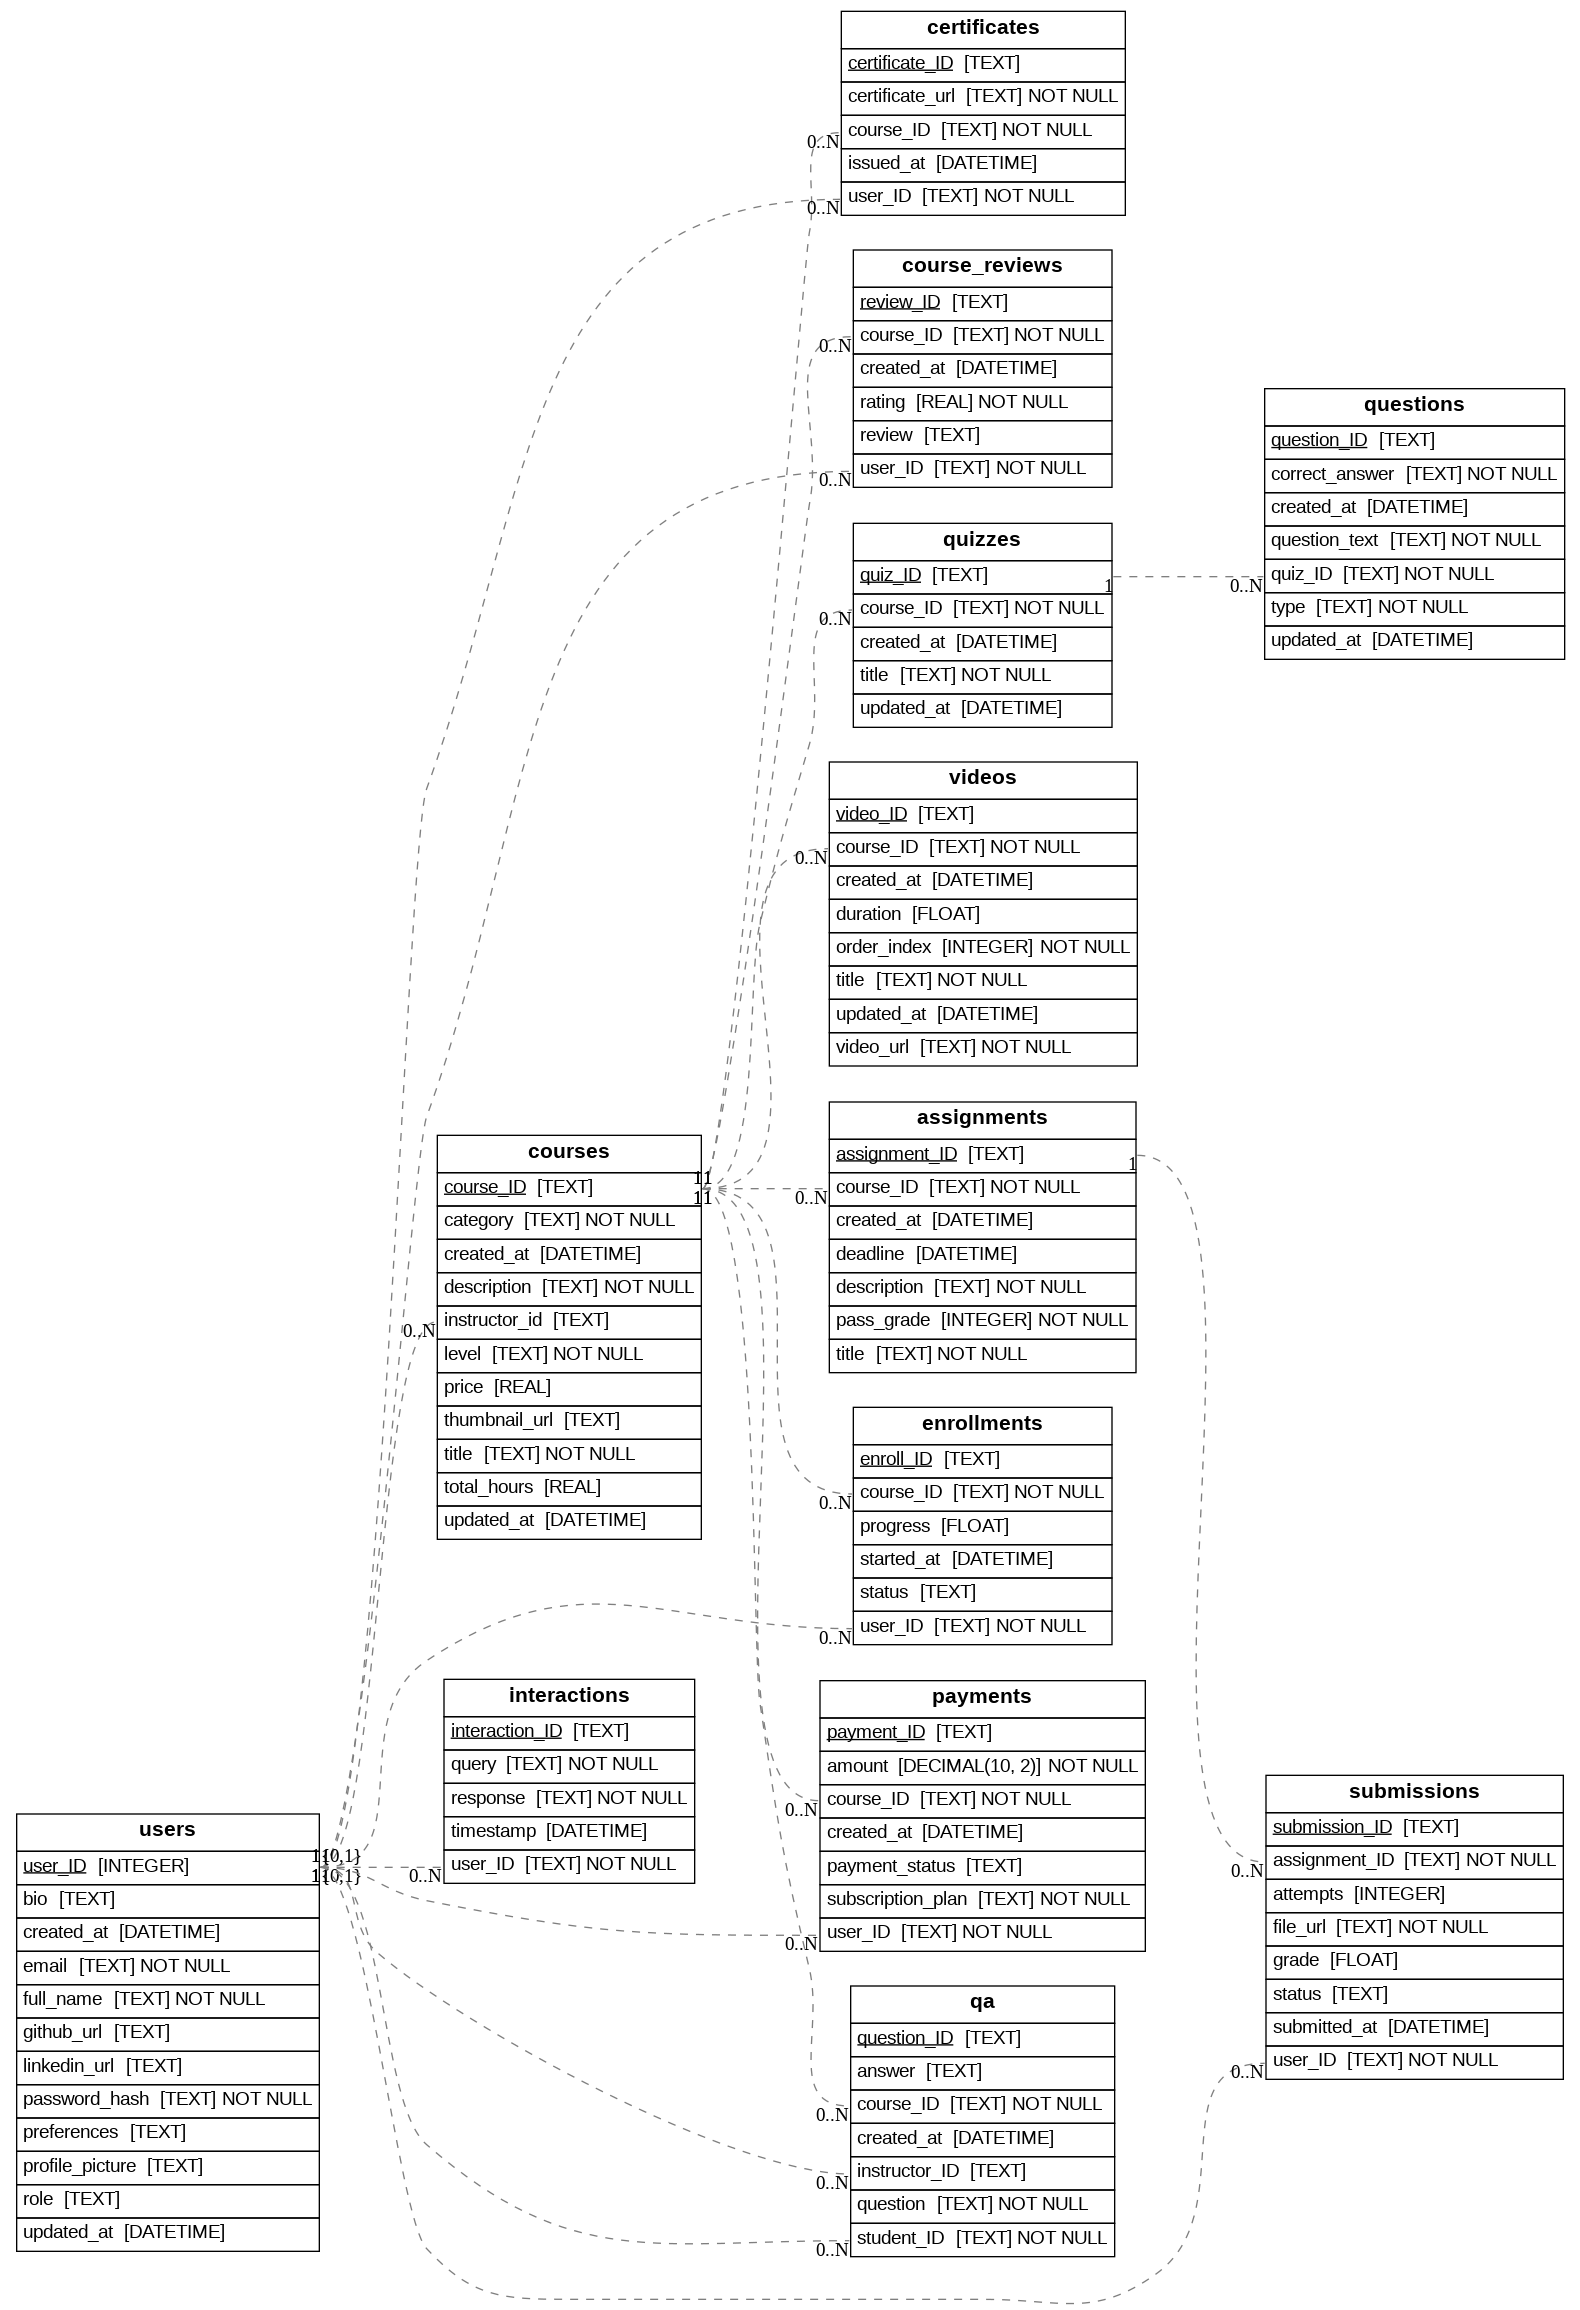

In [ ]:
# Draw the diagram
output_path = 'er_diagram.png'
# Generate ER diagram
render_er(f'sqlite:///{DB_NAME}', output_path)
# Display the ER diagram
Image(output_path)

## **2.2 : Verify Table Structure**

In [ ]:
def visualize_tables(db_path):
    """
    🚀 Visually presents each table's structure in an elegant and interactive format.

    📌 Features:
    ✅ Displays each table in a stylish format.
    ✅ Generates graphical schema images for each table and saves them in the 'structure' folder.
    ✅ Uses rich formatting for enhanced readability.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    console = Console()

    # 📂 Ensure 'structure' folder exists
    output_folder = "structure"
    os.makedirs(output_folder, exist_ok=True)

    try:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        # 🎯 Get all table names
        tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)['name']

        if tables.empty:
            console.print("[bold red]❌ No tables found in the database![/bold red]")
            return

        for table in tables:
            console.print(Panel(f"[bold cyan]📂 Table:[/bold cyan] [yellow]{table}[/yellow]", style="bold blue", expand=False))

            # 📊 Get table structure
            table_info = pd.read_sql_query(f"PRAGMA table_info({table});", conn)

            # 🎨 Create a stylish rich table
            rich_table = RichTable(title=f"📜 Structure of {table}", box=box.DOUBLE, header_style="bold magenta")
            rich_table.add_column("ID", style="cyan", justify="center")
            rich_table.add_column("Column Name", style="green")
            rich_table.add_column("Data Type", style="yellow", justify="center")
            rich_table.add_column("Not Null", style="red", justify="center")
            rich_table.add_column("Default Value", style="blue", justify="center")
            rich_table.add_column("Primary Key", style="bold white", justify="center")

            # 🎭 Graphviz for visual representation
            diagram = graphviz.Digraph(format='png', engine="dot")
            diagram.attr(rankdir='TB', bgcolor="white")
            diagram.node(table, shape="box", style="filled", fillcolor="lightblue", fontname="Arial")

            # 🛠 Populate table and diagram
            for _, row in table_info.iterrows():
                col_id, col_name, col_type, not_null, default_val, pk = row
                default_val = default_val if default_val is not None else "—"
                pk_status = "🔑" if pk else "—"
                not_null_status = "✅" if not_null else "—"

                rich_table.add_row(str(col_id), col_name, col_type, not_null_status, str(default_val), pk_status)

                # 🖼️ Add field to diagram
                diagram.node(col_name, shape="ellipse", style="filled", fillcolor="lightgray", fontname="Arial")
                diagram.edge(table, col_name, color="black")

            # 🖥️ Print the table structure
            console.print(rich_table)
            console.print("-" * 80)

            # 📷 Generate and save the table structure image in 'structure' folder
            image_path = os.path.join(output_folder, f"{table}_structure")
            diagram.render(image_path, format="png", cleanup=True)
            console.print(f"[bold green]✅ Table structure image saved in '{output_folder}/{table}_structure.png'[/bold green] 🎉\n")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")
    finally:
        conn.close()


In [ ]:
visualize_tables(DB_NAME)

╭─────────────────╮
│ 📂 Table: users │
╰─────────────────╯

                              📜 Structure of users                              
╔════╦═════════════════╦═══════════╦══════════╦═══════════════════╦═════════════╗
║ ID ║ Column Name     ║ Data Type ║ Not Null ║   Default Value   ║ Primary Key ║
╠════╬═════════════════╬═══════════╬══════════╬═══════════════════╬═════════════╣
║ 0  ║ user_ID         ║  INTEGER  ║    —     ║         —         ║     🔑      ║
║ 1  ║ full_name       ║   TEXT    ║    ✅    ║         —         ║      —      ║
║ 2  ║ email           ║   TEXT    ║    ✅    ║         —         ║      —      ║
║ 3  ║ password_hash   ║   TEXT    ║    ✅    ║         —         ║      —      ║
║ 4  ║ role            ║   TEXT    ║    —     ║         —         ║      —      ║
║ 5  ║ bio             ║   TEXT    ║    —     ║        ''         ║      —      ║
║ 6  ║ linkedin_url    ║   TEXT    ║    —     ║        ''         ║      —      ║
║ 7  ║ github_url      ║   TEXT    ║    —     ║        ''         ║      —      ║
║ 8  ║ profile_picture ║   TEXT    ║    —     ║        ''         ║      —      ║
║ 9  ║ preferences     ║   TEXT    ║    —     ║       '{}'        ║      —      ║
║ 10 ║ created_at      ║ DATETIME  ║    —     ║ CURRENT_TIMESTAMP ║      —      ║
║ 11 ║ updated_at      ║ DATETIME  ║    —     ║ CURRENT_TIMESTAMP ║      —      ║
╚════╩═════════════════╩═══════════╩══════════╩═══════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/users_structure.png' 🎉

╭───────────────────────────╮
│ 📂 Table: sqlite_sequence │
╰───────────────────────────╯

                     📜 Structure of sqlite_sequence                     
╔════╦═════════════╦═══════════╦══════════╦═══════════════╦═════════════╗
║ ID ║ Column Name ║ Data Type ║ Not Null ║ Default Value ║ Primary Key ║
╠════╬═════════════╬═══════════╬══════════╬═══════════════╬═════════════╣
║ 0  ║ name        ║           ║    —     ║       —       ║      —      ║
║ 1  ║ seq         ║           ║    —     ║       —       ║      —      ║
╚════╩═════════════╩═══════════╩══════════╩═══════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/sqlite_sequence_structure.png' 🎉

╭───────────────────╮
│ 📂 Table: courses │
╰───────────────────╯

                                📜 Structure of courses                                 
╔════╦═══════════════╦═══════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name   ║ Data Type ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬═══════════════╬═══════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ course_ID     ║   TEXT    ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ title         ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 2  ║ description   ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 3  ║ category      ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 4  ║ level         ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 5  ║ instructor_id ║   TEXT    ║    —     ║             —              ║      —      ║
║ 6  ║ price         ║   REAL    ║    —     ║            0.0             ║      —      ║
║ 7  ║ thumbnail_url ║   TEXT    ║    —     ║             —              ║      —      ║
║ 8  ║ total_hours   ║   REAL    ║    —     ║             0              ║      —      ║
║ 9  ║ created_at    ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
║ 10 ║ updated_at    ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
╚════╩═══════════════╩═══════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/courses_structure.png' 🎉

╭──────────────────╮
│ 📂 Table: videos │
╰──────────────────╯

                                📜 Structure of videos                                
╔════╦═════════════╦═══════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name ║ Data Type ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬═════════════╬═══════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ video_ID    ║   TEXT    ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ course_ID   ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 2  ║ title       ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 3  ║ video_url   ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 4  ║ duration    ║   FLOAT   ║    —     ║             0              ║      —      ║
║ 5  ║ order_index ║  INTEGER  ║    ✅    ║             —              ║      —      ║
║ 6  ║ created_at  ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
║ 7  ║ updated_at  ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
╚════╩═════════════╩═══════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/videos_structure.png' 🎉

╭───────────────────────╮
│ 📂 Table: enrollments │
╰───────────────────────╯

                             📜 Structure of enrollments                              
╔════╦═════════════╦═══════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name ║ Data Type ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬═════════════╬═══════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ enroll_ID   ║   TEXT    ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ user_ID     ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 2  ║ course_ID   ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 3  ║ status      ║   TEXT    ║    —     ║          'Unpaid'          ║      —      ║
║ 4  ║ progress    ║   FLOAT   ║    —     ║            0.0             ║      —      ║
║ 5  ║ started_at  ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
╚════╩═════════════╩═══════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/enrollments_structure.png' 🎉

╭───────────────────╮
│ 📂 Table: quizzes │
╰───────────────────╯

                               📜 Structure of quizzes                                
╔════╦═════════════╦═══════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name ║ Data Type ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬═════════════╬═══════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ quiz_ID     ║   TEXT    ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ course_ID   ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 2  ║ title       ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 3  ║ created_at  ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
║ 4  ║ updated_at  ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
╚════╩═════════════╩═══════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/quizzes_structure.png' 🎉

╭─────────────────────╮
│ 📂 Table: questions │
╰─────────────────────╯

                                📜 Structure of questions                                
╔════╦════════════════╦═══════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name    ║ Data Type ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬════════════════╬═══════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ question_ID    ║   TEXT    ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ quiz_ID        ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 2  ║ question_text  ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 3  ║ type           ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 4  ║ correct_answer ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 5  ║ created_at     ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
║ 6  ║ updated_at     ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
╚════╩════════════════╩═══════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/questions_structure.png' 🎉

╭───────────────────────╮
│ 📂 Table: assignments │
╰───────────────────────╯

                              📜 Structure of assignments                               
╔════╦═══════════════╦═══════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name   ║ Data Type ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬═══════════════╬═══════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ assignment_ID ║   TEXT    ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ course_ID     ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 2  ║ title         ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 3  ║ description   ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 4  ║ deadline      ║ DATETIME  ║    —     ║             —              ║      —      ║
║ 5  ║ pass_grade    ║    INT    ║    ✅    ║             —              ║      —      ║
║ 6  ║ created_at    ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
╚════╩═══════════════╩═══════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/assignments_structure.png' 🎉

╭───────────────────────╮
│ 📂 Table: submissions │
╰───────────────────────╯

                              📜 Structure of submissions                               
╔════╦═══════════════╦═══════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name   ║ Data Type ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬═══════════════╬═══════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ submission_ID ║   TEXT    ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ user_ID       ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 2  ║ assignment_ID ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 3  ║ file_url      ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 4  ║ grade         ║   FLOAT   ║    —     ║            NULL            ║      —      ║
║ 5  ║ submitted_at  ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
║ 6  ║ attempts      ║    INT    ║    —     ║             0              ║      —      ║
║ 7  ║ status        ║   TEXT    ║    —     ║      'Not Submitted'       ║      —      ║
╚════╩═══════════════╩═══════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/submissions_structure.png' 🎉

╭──────────────╮
│ 📂 Table: qa │
╰──────────────╯

                                   📜 Structure of qa                                   
╔════╦═══════════════╦═══════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name   ║ Data Type ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬═══════════════╬═══════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ question_ID   ║   TEXT    ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ course_ID     ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 2  ║ student_ID    ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 3  ║ instructor_ID ║   TEXT    ║    —     ║             —              ║      —      ║
║ 4  ║ question      ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 5  ║ answer        ║   TEXT    ║    —     ║            NULL            ║      —      ║
║ 6  ║ created_at    ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
╚════╩═══════════════╩═══════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/qa_structure.png' 🎉

╭────────────────────────╮
│ 📂 Table: interactions │
╰────────────────────────╯

                              📜 Structure of interactions                               
╔════╦════════════════╦═══════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name    ║ Data Type ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬════════════════╬═══════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ interaction_ID ║   TEXT    ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ user_ID        ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 2  ║ query          ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 3  ║ response       ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 4  ║ timestamp      ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
╚════╩════════════════╩═══════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/interactions_structure.png' 🎉

╭──────────────────────────╮
│ 📂 Table: course_reviews │
╰──────────────────────────╯

                            📜 Structure of course_reviews                            
╔════╦═════════════╦═══════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name ║ Data Type ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬═════════════╬═══════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ review_ID   ║   TEXT    ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ user_ID     ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 2  ║ course_ID   ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 3  ║ rating      ║   REAL    ║    ✅    ║             —              ║      —      ║
║ 4  ║ review      ║   TEXT    ║    —     ║            NULL            ║      —      ║
║ 5  ║ created_at  ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
╚════╩═════════════╩═══════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/course_reviews_structure.png' 🎉

╭────────────────────────╮
│ 📂 Table: certificates │
╰────────────────────────╯

                               📜 Structure of certificates                               
╔════╦═════════════════╦═══════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name     ║ Data Type ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬═════════════════╬═══════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ certificate_ID  ║   TEXT    ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ user_ID         ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 2  ║ course_ID       ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 3  ║ certificate_url ║   TEXT    ║    ✅    ║             —              ║      —      ║
║ 4  ║ issued_at       ║ DATETIME  ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
╚════╩═════════════════╩═══════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/certificates_structure.png' 🎉

╭────────────────────╮
│ 📂 Table: payments │
╰────────────────────╯

                                    📜 Structure of payments                                    
╔════╦═══════════════════╦═══════════════╦══════════╦════════════════════════════╦═════════════╗
║ ID ║ Column Name       ║   Data Type   ║ Not Null ║       Default Value        ║ Primary Key ║
╠════╬═══════════════════╬═══════════════╬══════════╬════════════════════════════╬═════════════╣
║ 0  ║ payment_ID        ║     TEXT      ║    —     ║ lower(hex(randomblob(16))) ║     🔑      ║
║ 1  ║ user_ID           ║     TEXT      ║    ✅    ║             —              ║      —      ║
║ 2  ║ course_ID         ║     TEXT      ║    ✅    ║             —              ║      —      ║
║ 3  ║ subscription_plan ║     TEXT      ║    ✅    ║             —              ║      —      ║
║ 4  ║ amount            ║ DECIMAL(10,2) ║    ✅    ║             —              ║      —      ║
║ 5  ║ payment_status    ║     TEXT      ║    —     ║         'Pending'          ║      —      ║
║ 6  ║ created_at        ║   DATETIME    ║    —     ║     CURRENT_TIMESTAMP      ║      —      ║
╚════╩═══════════════════╩═══════════════╩══════════╩════════════════════════════╩═════════════╝

--------------------------------------------------------------------------------

✅ Table structure image saved in 'structure/payments_structure.png' 🎉

# **3 Insert Some Data to the tables**

In [ ]:
def display_table_sample(db_path, table_name, num_samples=5):
    """
    📌 Displays a visually impressive sample of a table from an SQLite database.

    ✅ Uses Rich to display a stunning, colorful table.
    ✅ Falls back to Tabulate for larger samples.
    ✅ Shows column headers, formatted data, and handles empty tables gracefully.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    console = Console()

    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        query = f"SELECT * FROM {table_name} ORDER BY RANDOM() LIMIT {num_samples};"
        df = pd.read_sql_query(query, conn)

        if df.empty:
            console.print(f"[bold red]❌ No data found in table '{table_name}'![/bold red]")
            return

        # 🎨 Display using Rich if sample size is small
        if num_samples <= 10:
            table = Table(title=f"📊 Sample Data from '{table_name}'", box=box.DOUBLE, highlight=True)
            for col in df.columns:
                table.add_column(col, style="cyan", justify="center")

            for _, row in df.iterrows():
                table.add_row(*[str(value) for value in row])

            console.print(table)

        # 📜 If more than 10 samples, use Tabulate for readability
        else:
            console.print(f"\n📌 Showing {num_samples} samples from '{table_name}':\n")
            print(tabulate(df, headers="keys", tablefmt="fancy_grid"))

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()

In [ ]:
# 🎨 Custom rich theme for stylish console output
custom_theme = Theme({
    "title": "bold magenta",
    "info": "bold cyan",
    "data": "bold yellow",
    "error": "bold red"
})
console = Console(theme=custom_theme)

def visualize_dataset(csv_path):
    """
    🔥 Impressively Visualizes a Dataset with:
    ✅ Unique values in categorical columns
    ✅ Column names with rich formatting
    ✅ Dark-themed interactive visualizations using Plotly

    📧 Author: Basel Amr Barakat
    """
    try:
        # 🚀 Load dataset
        df = pd.read_csv(csv_path)

        # 🎭 Identify categorical and numerical columns
        cat_cols = df.select_dtypes(include=['object']).columns
        num_cols = df.select_dtypes(include=['number']).columns

        # 🎨 Title in the middle
        console.print(Panel("🔥 [bold magenta] Dataset Overview [/bold magenta] 🔥", style="bold blue"))

        # 📂 Display Column Names
        table = Table(title="📋 Column Names", header_style="bold yellow", box=SIMPLE)
        table.add_column("Index", style="cyan", justify="center")
        table.add_column("Column Name", style="bold white", justify="left")
        for i, col in enumerate(df.columns):
            table.add_row(str(i), col)
        console.print(table)

        # 🎭 Show Unique Values for Categorical Columns
        if len(cat_cols) > 0:
            console.print(Panel("🎭 [bold cyan] Unique Values in Categorical Columns [/bold cyan]", style="bold blue"))
            for col in cat_cols:
                console.print(f"📌 [bold cyan]{col}[/bold cyan]: {df[col].nunique()} unique values")
                console.print(f"📝 [yellow]{df[col].unique()[:10]}...[/yellow]")  # Show first 10 unique values
            console.print("-" * 80)

        # 🔢 Show Statistical Summary for Numerical Data
        console.print(Panel("📊 [bold green] Numerical Data Summary [/bold green]", style="bold blue"))
        console.print(df.describe())

        # 🎨 Dark Theme Visualizations with Plotly
        if len(num_cols) > 0:
            fig = px.histogram(df, x=num_cols[0],
                               title=f"🔥 Distribution of {num_cols[0]} 🔥",
                               template="plotly_dark",
                               color_discrete_sequence=["cyan"])
            fig.update_layout(title_x=0.5)  # Center the title
            fig.show()
        else:
            console.print("[bold red]❌ No numerical columns found for visualization![/bold red]")

    except Exception as e:
        console.print(f"[error]❌ Error:[/error] {e}")

In [ ]:
# 🛠️ Usage Example:
visualize_dataset("udemy_course_data.csv")

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🔥  Dataset Overview  🔥                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

        📋 Column Names        
                               
  Index   Column Name          
 ───────────────────────────── 
    0     course_id            
    1     course_title         
    2     url                  
    3     is_paid              
    4     price                
    5     num_subscribers      
    6     num_reviews          
    7     num_lectures         
    8     level                
    9     content_duration     
   10     published_timestamp  
   11     subject              
   12     profit               
   13     published_date       
   14     published_time       
   15     year                 
   16     month                
   17     day                 

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 🎭  Unique Values in Categorical Columns                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

📌 course_title: 3668 unique values

📝 ['Ultimate Investment Banking Course'
 'Complete GST Course & Certification - Grow Your CA Practice'
 'Financial Modeling for Business Analysts and Consultants'
 'Beginner to Pro - Financial Analysis in Excel 2017'
 'How To Maximize Your Profits Trading Options'
 'Trading Penny Stocks: A Guide for All Levels In 2017'
 'Investing And Trading For Beginners: Mastering Price Charts'
 'Trading Stock Chart Patterns For Immediate, Explosive Gains'
 'Options Trading 3 : Advanced Stock Profit and Success Method'
 'The Only Investment Strategy You Need For Your Retirement']...

📌 url: 3677 unique values

📝 ['https://www.udemy.com/ultimate-investment-banking-course/'
 'https://www.udemy.com/goods-and-services-tax/'
 'https://www.udemy.com/financial-modeling-for-business-analysts-and-consultants/'
 'https://www.udemy.com/complete-excel-finance-course-from-beginner-to-pro/'
 'https://www.udemy.com/how-to-maximize-your-profits-trading-options/'
 'https://www.udemy.com/trading-penny-stocks-a-guide-for-all-levels/'
 'https://www.udemy.com/investing-and-trading-for-beginners-mastering-price-charts/'
 'https://www.udemy.com/trading-chart-patterns-for-immediate-explosive-gains/'
 'https://www.udemy.com/day-trading-stock-options-3/'
 'https://www.udemy.com/the-only-investment-strategy-you-need-for-your-retirement/']...

📌 level: 5 unique values

📝 ['All Levels' 'Intermediate Level' 'Beginner Level' 'Expert Level' '52']...

📌 content_duration: 110 unique values

📝 ['1.5 hours' '39 hours' '2.5 hours' '3 hours' '2 hours' '1 hour' '5 hours'
 '7 hours' '4 hours' '35 mins']...

📌 published_timestamp: 3677 unique values

📝 ['2017-01-18T20:58:58Z' '2017-03-09T16:34:20Z' '2016-12-19T19:26:30Z'
 '2017-05-30T20:07:24Z' '2016-12-13T14:57:18Z' '2014-05-02T15:13:30Z'
 '2016-02-21T18:23:12Z' '2015-01-30T22:13:03Z' '2015-05-28T00:14:03Z'
 '2017-04-18T18:13:32Z']...

📌 subject: 4 unique values

📝 ['Business Finance' 'Graphic Design' 'Musical Instruments'
 'Web Development']...

📌 published_date: 1210 unique values

📝 ['2017-01-18' '2017-03-09' '2016-12-19' '2017-05-30' '2016-12-13'
 '2014-05-02' '2016-02-21' '2015-01-30' '2015-05-28' '2017-04-18']...

📌 published_time: 3552 unique values

📝 ['20:58:58Z' '16:34:20Z' '19:26:30Z' '20:07:24Z' '14:57:18Z' '15:13:30Z'
 '18:23:12Z' '22:13:03Z' '00:14:03Z' '18:13:32Z']...

--------------------------------------------------------------------------------

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 📊  Numerical Data Summary                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

course_id        price  num_subscribers   num_reviews  num_lectures  \
count  3.683000e+03  3683.000000      3683.000000   3683.000000   3683.000000   
mean   6.764546e+05    65.992398      3193.371165    156.448004     40.062178   
std    3.437217e+05    60.985586      9498.231406    935.078241     50.366788   
min    8.324000e+03     0.000000         0.000000      0.000000      0.000000   
25%    4.077270e+05    20.000000       110.000000      4.000000     15.000000   
50%    6.882440e+05    45.000000       911.000000     18.000000     25.000000   
75%    9.617290e+05    95.000000      2537.500000     67.000000     45.000000   
max    1.282064e+06   200.000000    268923.000000  27445.000000    779.000000   

             profit         year        month          day  
count  3.683000e+03  3683.000000  3683.000000  3683.000000  
mean   2.402885e+05  2015.433342     6.162639    15.841162  
std    1.000760e+06     1.185920     3.379314     8.780906  
min    0.000000e+00  2011.000000     1.000000     1.000000  
25%    1.567500e+03  2015.000000     3.000000     8.000000  
50%    2.305000e+04  2016.000000     6.000000    16.000000  
75%    1.182600e+05  2016.000000     9.000000    23.000000  
max    2.431680e+07  2017.000000    12.000000    31.000000

## **3.1 Insert Data into course table**

### **3.1.1 Load Excel data**

In [ ]:
file_path = "udemy_course_data.csv"
df = pd.read_csv(file_path)

### **3.1.2 Rename columns to match the table**

In [ ]:
# Rename columns to match the table
df.rename(columns={
    "course_title": "course_title",
    "subject": "category",
    "level": "level",
    "price": "price",
    "content_duration": "total_hours",
    "published_timestamp": "created_at"
}, inplace=True)

In [ ]:
# Normalize the 'level' column
level_mapping = {
    "Beginner Level": "Beginner",
    "Intermediate Level": "Intermediate",
    "Expert Level": "Advanced",
    "All Levels": "Beginner"  # Assigning a default category
}
df["level"] = df["level"].map(level_mapping).fillna("Beginner")

In [ ]:
# Convert 'total_hours' to float
def convert_duration(duration):
    if "hour" in duration:
        hours = re.findall(r"[\d.]+", duration)
        return float(hours[0]) if hours else 0
    elif "min" in duration:
        mins = re.findall(r"[\d.]+", duration)
        return float(mins[0]) / 60 if mins else 0
    return 0

df["total_hours"] = df["total_hours"].astype(str).apply(convert_duration)

In [ ]:
# Add required columns
df["description"] = "No description available"
df["thumbnail_url"] = None
df["updated_at"] = df["created_at"]

In [ ]:
# Select only relevant columns
df = df[["course_title", "description", "category", "level", "price", "thumbnail_url", "total_hours", "created_at", "updated_at"]]

### **3.1.1 Generate Course ID**

In [ ]:
def generate_course_id():
    """Generate a unique 32-character hexadecimal course ID."""
    return ''.join(random.choices(string.hexdigits.lower(), k=32))

### **3.1.2 Convert Duration**

In [ ]:
def convert_duration(duration):
    """Convert duration from 'X hours' or 'X mins' to float (total hours)."""
    if pd.isna(duration):
        return 0.0
    try:
        if "hour" in duration:
            return float(duration.split()[0])
        elif "min" in duration:
            return round(float(duration.split()[0]) / 60, 2)
    except:
        return 0.0
    return 0.0

### **3.1.3 map level**

In [ ]:
def map_level(level):
    """Map CSV levels to database levels (Beginner, Intermediate, Advanced)."""
    level_mapping = {
        "Beginner Level": "Beginner",
        "Intermediate Level": "Intermediate",
        "Expert Level": "Advanced",
        "All Levels": "Intermediate"  # Assuming 'All Levels' maps to 'Intermediate'
    }
    return level_mapping.get(level, "Beginner")  # Default to Beginner if unknown

### **3.1.4 Insert Actual data**

In [ ]:
def insert_actual_data(db_path, csv_path, table_name):
    """
    📌 Inserts data from a CSV file into an SQLite database.

    ✅ Automatically maps CSV columns to database columns.
    ✅ Ensures the table exists before inserting data.
    ✅ Handles data type conversions gracefully.
    ✅ Uses default values for missing columns.
    """
    console = Console()

    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        # 📂 Load CSV into Pandas
        df = pd.read_csv(csv_path)

        if df.empty:
            console.print("[bold red]❌ The dataset is empty![/bold red]")
            return

        # 🔍 Check if the table exists
        table_check_query = f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}';"
        cursor.execute(table_check_query)
        table_exists = cursor.fetchone()

        if not table_exists:
            console.print(f"[bold red]❌ Table '{table_name}' does not exist![/bold red]")
            return

        # 🎯 Select & Transform Necessary Columns
        df_transformed = pd.DataFrame()
        df_transformed["course_ID"] = [generate_course_id() for _ in range(len(df))]
        df_transformed["course_title"] = df["course_title"]
        df_transformed["description"] = df["course_title"]
        df_transformed["category"] = df["subject"]
        df_transformed["level"] = df["level"].apply(map_level)
        df_transformed["instructor_id"] = None  # Placeholder, assuming no instructor data
        df_transformed["price"] = df["price"].astype(float)
        df_transformed["thumbnail_url"] = df["url"]
        df_transformed["total_hours"] = df["content_duration"].apply(convert_duration)
        df_transformed["created_at"] = df["published_date"].apply(lambda x: x + " 00:00:00" if pd.notna(x) else datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        df_transformed["updated_at"] = df_transformed["created_at"]

        # 🛠 Insert data into the table
        df_transformed.to_sql(table_name, conn, if_exists="append", index=False)

        console.print(f"[bold green]✅ Successfully inserted {len(df_transformed)} rows into '{table_name}'![/bold green] 🎉")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()

In [ ]:
table_name = "courses"
insert_actual_data(DB_NAME, file_path, table_name)

✅ Successfully inserted 3683 rows into 'courses'! 🎉

In [ ]:
display_table_sample(DB_NAME, table_name, 5)

                                           📊 Sample Data from 'courses'                                           
╔══════════╦══════════╦═════════╦══════════╦═════════╦══════════╦═══════╦═════════╦══════════╦═════════╦══════════╗
║ course_… ║ course_… ║ descri… ║ category ║  level  ║ instruc… ║ price ║ thumbn… ║ total_h… ║ create… ║ updated… ║
╠══════════╬══════════╬═════════╬══════════╬═════════╬══════════╬═══════╬═════════╬══════════╬═════════╬══════════╣
║ b2ef0c2… ║ Serverl… ║ Server… ║   Web    ║ Interm… ║   None   ║  0.0  ║ https:… ║   0.55   ║ 2016-1… ║ 2016-11… ║
║          ║ Archite… ║ Archit… ║ Develop… ║         ║          ║       ║         ║          ║ 00:00:… ║ 00:00:00 ║
║          ║    on    ║   on    ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║  Amazon  ║ Amazon  ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║   Web    ║   Web   ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║ Services ║ Servic… ║          ║         ║          ║       ║         ║          ║         ║          ║
║ 9edc915… ║ The Holy ║   The   ║ Business ║ Interm… ║   None   ║ 50.0  ║ https:… ║   1.0    ║ 2016-0… ║ 2016-05… ║
║          ║ Grail of ║  Holy   ║ Finance  ║         ║          ║       ║         ║          ║ 00:00:… ║ 00:00:00 ║
║          ║   Auto   ║  Grail  ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║ Trading  ║ of Auto ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║  Forex   ║ Trading ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║ Futures  ║  Forex  ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║  Stocks  ║ Futures ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║ Revealed ║ Stocks  ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║          ║ Reveal… ║          ║         ║          ║       ║         ║          ║         ║          ║
║ 7a9a95e… ║ Options  ║ Options ║ Business ║ Interm… ║   None   ║  0.0  ║ https:… ║   4.0    ║ 2017-0… ║ 2017-04… ║
║          ║ Trading  ║ Trading ║ Finance  ║         ║          ║       ║         ║          ║ 00:00:… ║ 00:00:00 ║
║          ║ Essenti… ║ Essent… ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║   The    ║   The   ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║ ULTIMATE ║ ULTIMA… ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║  Guides  ║ Guides  ║          ║         ║          ║       ║         ║          ║         ║          ║
║ 02dea62… ║  Learn   ║  Learn  ║   Web    ║ Interm… ║   None   ║ 110.0 ║ https:… ║   5.5    ║ 2016-0… ║ 2016-09… ║
║          ║ Node.js  ║ Node.js ║ Develop… ║         ║          ║       ║         ║          ║ 00:00:… ║ 00:00:00 ║
║          ║    by    ║   by    ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║ building ║ buildi… ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║  Udemy:  ║ Udemy:  ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║ Stripe + ║ Stripe  ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║ MailChi… ║    +    ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║ + Wistia ║ MailCh… ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║          ║    +    ║          ║         ║          ║       ║         ║          ║         ║          ║
║          ║          ║ Wistia  ║          ║         ║   

## **3.2 Insert Data into Users Table**

In [ ]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.0 MB/s eta 0:00:00


In [ ]:
from faker import Faker
import json
from rich.progress import track

In [ ]:
faker = Faker()

In [ ]:
def insert_fake_users(db_path, num_users=10):
    """
    📌 Inserts realistic fake users into the 'users' table in an SQLite database.

    ✅ Generates names, emails, bios, LinkedIn/GitHub links, and secure passwords.
    ✅ Ensures constraints are met (valid email, strong passwords, correct roles).
    ✅ Uses Rich to display progress and success messages in a stunning way.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    roles = ["student", "instructor", "admin"]  # Allowed roles

    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        console.print(f"\n[bold cyan]🚀 Inserting {num_users} fake users into the database...[/bold cyan]")

        # 🌟 Generate and insert fake users
        for _ in track(range(num_users), description="[bold yellow]Generating users...[/bold yellow]"):
            full_name = faker.name()
            email = faker.unique.email()
            password_hash = faker.password(length=12)
            role = random.choice(roles)
            bio = faker.sentence()
            linkedin_url = f"https://www.linkedin.com/in/{full_name.replace(' ', '').lower()}"
            github_url = f"https://github.com/{full_name.replace(' ', '').lower()}"
            profile_picture = faker.image_url()
            preferences = json.dumps({"theme": "dark", "notifications": True})
            created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            updated_at = created_at

            # 🔹 Insert data into the database
            cursor.execute("""
                INSERT INTO users (full_name, email, password_hash, role, bio, linkedin_url,
                                   github_url, profile_picture, preferences, created_at, updated_at)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            """, (full_name, email, password_hash, role, bio, linkedin_url, github_url, profile_picture, preferences, created_at, updated_at))

        conn.commit()  # ✅ Save changes
        console.print(f"\n[bold green]✅ Successfully inserted {num_users} fake users! 🎉[/bold green]")

        # 📊 Display a preview of inserted users
        display_table_sample(db_path, "users", min(num_users, 5))

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()

In [ ]:
insert_fake_users(DB_NAME, num_users=25)

🚀 Inserting 25 fake users into the database...

Output()

✅ Successfully inserted 25 fake users! 🎉

                                            📊 Sample Data from 'users'                                            
╔═════════╦════════╦═════════╦════════╦═════════╦════════╦═════════╦════════╦═════════╦════════╦═════════╦════════╗
║ user_ID ║ full_… ║  email  ║ passw… ║  role   ║  bio   ║ linked… ║ githu… ║ profil… ║ prefe… ║ create… ║ updat… ║
╠═════════╬════════╬═════════╬════════╬═════════╬════════╬═════════╬════════╬═════════╬════════╬═════════╬════════╣
║   25    ║ Sandra ║ johnso… ║ 2qCA^… ║ student ║  Call  ║ https:… ║ https… ║ https:… ║ {"the… ║ 2025-0… ║ 2025-… ║
║         ║ Reyes  ║         ║        ║         ║  rest  ║         ║        ║         ║ "dark… ║ 18:00:… ║ 18:00… ║
║         ║        ║         ║        ║         ║ during ║         ║        ║         ║ "noti… ║         ║        ║
║         ║        ║         ║        ║         ║ chall… ║         ║        ║         ║ true}  ║         ║        ║
║         ║        ║         ║        ║         ║ might  ║         ║        ║         ║        ║         ║        ║
║         ║        ║         ║        ║         ║  let.  ║         ║        ║         ║        ║         ║        ║
║   16    ║ Joanna ║ riosas… ║ ^VUk7… ║  admin  ║ Resou… ║ https:… ║ https… ║ https:… ║ {"the… ║ 2025-0… ║ 2025-… ║
║         ║ Gibbs  ║         ║        ║         ║  boy   ║         ║        ║         ║ "dark… ║ 18:00:… ║ 18:00… ║
║         ║        ║         ║        ║         ║ estab… ║         ║        ║         ║ "noti… ║         ║        ║
║         ║        ║         ║        ║         ║ activ… ║         ║        ║         ║ true}  ║         ║        ║
║    7    ║ Kayla  ║ tylerm… ║ 5X*2Y… ║  admin  ║  Than  ║ https:… ║ https… ║ https:… ║ {"the… ║ 2025-0… ║ 2025-… ║
║         ║ Herna… ║         ║        ║         ║   as   ║         ║        ║         ║ "dark… ║ 18:00:… ║ 18:00… ║
║         ║        ║         ║        ║         ║ garden ║         ║        ║         ║ "noti… ║         ║        ║
║         ║        ║         ║        ║         ║  girl  ║         ║        ║         ║ true}  ║         ║        ║
║         ║        ║         ║        ║         ║ alway… ║         ║        ║         ║        ║         ║        ║
║   24    ║ Erica  ║ nchoi@… ║ %4F^%… ║  admin  ║  Even  ║ https:… ║ https… ║ https:… ║ {"the… ║ 2025-0… ║ 2025-… ║
║         ║ Deleon ║         ║        ║         ║  leg   ║         ║        ║         ║ "dark… ║ 18:00:… ║ 18:00… ║
║         ║        ║         ║        ║         ║ alrea… ║         ║        ║         ║ "noti… ║         ║        ║
║         ║        ║         ║        ║         ║ it old ║         ║        ║         ║ true}  ║         ║        ║
║         ║        ║         ║        ║         ║ score. ║         ║        ║         ║        ║         ║        ║
║   21    ║ James  ║ deanti… ║ 9z95B… ║  admin  ║ Prepa… ║ https:… ║ https… ║ https:… ║ {"the… ║ 2025-0… ║ 2025-… ║
║         ║ Johns… ║         ║        ║         ║  stay  ║         ║        ║         ║ "dark… ║ 18:00:… ║ 18:00… ║
║         ║        ║         ║        ║         ║ night  ║         ║        ║         ║ "noti… ║         ║        ║
║         ║        ║         ║        ║         ║  you.  ║         ║        ║         ║ true}  ║         ║        ║
╚═════════╩════════╩═════════╩════════╩═════════╩════════╩═════════╩════════╩═════════╩════════╩═════════╩════════╝

## **3.3 Insert Data into Videos Table**

In [ ]:
def insert_fake_videos(db_path, num_videos=10):
    """
    📌 Inserts realistic fake videos into the 'videos' table in an SQLite database.

    ✅ Generates random course IDs, video titles, URLs, durations, and order indices.
    ✅ Uses Rich for stunning CLI visuals with progress bars and success messages.
    ✅ Ensures data constraints are met (foreign keys, valid durations, etc.).
    """
    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        console.print(f"\n[bold cyan]🚀 Inserting {num_videos} fake videos into the database...[/bold cyan]")

        # 🔍 Fetch all available course IDs to link videos correctly
        cursor.execute("SELECT course_ID FROM courses")
        course_ids = [row[0] for row in cursor.fetchall()]

        if not course_ids:
            console.print("[bold red]❌ No courses found! Please add courses first.[/bold red]")
            return

        # 🎥 Generate and insert fake videos
        for _ in track(range(num_videos), description="[bold yellow]Generating videos...[/bold yellow]"):
            video_id = faker.uuid4()
            course_id = random.choice(course_ids)  # Randomly assign an existing course
            title = faker.sentence(nb_words=5).replace(".", "")
            video_url = f"https://www.example.com/videos/{video_id}"
            duration = round(random.uniform(3, 180), 2)  # Duration between 3 sec and 3 hours
            order_index = random.randint(1, 50)
            created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            updated_at = created_at

            # 🔹 Insert data into the database
            cursor.execute("""
                INSERT INTO videos (video_ID, course_ID, title, video_url, duration, order_index, created_at, updated_at)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            """, (video_id, course_id, title, video_url, duration, order_index, created_at, updated_at))

        conn.commit()  # ✅ Save changes
        console.print(f"\n[bold green]✅ Successfully inserted {num_videos} fake videos! 🎉[/bold green]")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()

In [ ]:
insert_fake_videos(DB_NAME, num_videos=35)

🚀 Inserting 35 fake videos into the database...

Output()

✅ Successfully inserted 35 fake videos! 🎉

In [ ]:
display_table_sample(DB_NAME, "videos", 5)

                                           📊 Sample Data from 'videos'                                            
╔══════════════╦══════════════╦══════════════╦══════════════╦══════════╦═════════════╦═════════════╦══════════════╗
║   video_ID   ║  course_ID   ║    title     ║  video_url   ║ duration ║ order_index ║ created_at  ║  updated_at  ║
╠══════════════╬══════════════╬══════════════╬══════════════╬══════════╬═════════════╬═════════════╬══════════════╣
║ 40d8282b-9b… ║ cfdb83eeb6e… ║ Star him hot ║ https://www… ║  104.8   ║      2      ║ 2025-03-24  ║  2025-03-24  ║
║              ║              ║  difficult   ║              ║          ║             ║  18:02:16   ║   18:02:16   ║
║              ║              ║   long act   ║              ║          ║             ║             ║              ║
║              ║              ║    agent     ║              ║          ║             ║             ║              ║
║ 78eb2afe-99… ║ eff5add92f1… ║  Lot large   ║ https://www… ║  111.51  ║     28      ║ 2025-03-24  ║  2025-03-24  ║
║              ║              ║     born     ║              ║          ║             ║  18:02:16   ║   18:02:16   ║
║ cfd9c947-8a… ║ ee4524bf00d… ║  Scientist   ║ https://www… ║  71.45   ║     48      ║ 2025-03-24  ║  2025-03-24  ║
║              ║              ║  candidate   ║              ║          ║             ║  18:02:28   ║   18:02:28   ║
║              ║              ║   million    ║              ║          ║             ║             ║              ║
║              ║              ║   forward    ║              ║          ║             ║             ║              ║
║ d5796771-15… ║ 7c07a49cfaa… ║  So author   ║ https://www… ║  78.24   ║     39      ║ 2025-03-24  ║  2025-03-24  ║
║              ║              ║    letter    ║              ║          ║             ║  18:02:28   ║   18:02:28   ║
║              ║              ║ receive fine ║              ║          ║             ║             ║              ║
║ 27747e3e-1f… ║ 3c07ee2bbd6… ║  Mrs cover   ║ https://www… ║  133.87  ║     45      ║ 2025-03-24  ║  2025-03-24  ║
║              ║              ║   vote oil   ║              ║          ║             ║  18:02:28   ║   18:02:28   ║
╚══════════════╩══════════════╩══════════════╩══════════════╩══════════╩═════════════╩═════════════╩══════════════╝

## **3.4 Insert Data into Enrollments Table**

In [ ]:
def insert_smart_fake_enrollments(db_path, active_ratio=0.3, completed_ratio=0.2):
    """
    📌 Inserts structured fake enrollments into the 'enrollments' table.

    ✅ Every user is enrolled in at least one course with 'Unpaid' status.
    ✅ A portion of users transition to 'Active' with progress.
    ✅ Another portion transition to 'Completed' with 100% progress.
    ✅ Uses Rich for beautiful CLI visuals and progress tracking.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        console.print(f"\n[bold cyan]🚀 Enrolling all users with structured status distribution...[/bold cyan]")

        # 🔍 Fetch all available user IDs and course IDs
        cursor.execute("SELECT user_ID FROM users")
        user_ids = [row[0] for row in cursor.fetchall()]

        cursor.execute("SELECT course_ID FROM courses")
        course_ids = [row[0] for row in cursor.fetchall()]

        if not user_ids or not course_ids:
            console.print("[bold red]❌ No users or courses found! Please add users and courses first.[/bold red]")
            return

        # 🎓 Enrollment status distribution
        total_users = len(user_ids)
        num_active = int(total_users * active_ratio)
        num_completed = int(total_users * completed_ratio)

        # 🛠 Shuffle users before assigning statuses
        random.shuffle(user_ids)

        # 🟥 Step 1: Enroll everyone as "Unpaid"
        for user_id in track(user_ids, description="[bold yellow]Enrolling users as Unpaid...[/bold yellow]"):
            enroll_id = faker.uuid4()
            course_id = random.choice(course_ids)  # Random course
            status = "Unpaid"
            progress = 0.0
            started_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # 🔹 Insert into database
            cursor.execute("""
                INSERT INTO enrollments (enroll_ID, user_ID, course_ID, status, progress, started_at)
                VALUES (?, ?, ?, ?, ?, ?)
            """, (enroll_id, user_id, course_id, status, progress, started_at))

        # 🟦 Step 2: Convert some users to "Active" with random progress
        for user_id in track(user_ids[:num_active], description="[bold blue]Updating some users to Active...[/bold blue]"):
            progress = round(random.uniform(10, 90), 2)
            cursor.execute("""
                UPDATE enrollments
                SET status = 'Active', progress = ?
                WHERE user_ID = ?
            """, (progress, user_id))

        # 🟩 Step 3: Convert some users to "Completed" with 100% progress
        for user_id in track(user_ids[num_active:num_active + num_completed], description="[bold green]Updating some users to Completed...[/bold green]"):
            cursor.execute("""
                UPDATE enrollments
                SET status = 'Completed', progress = 100
                WHERE user_ID = ?
            """, (user_id,))

        conn.commit()  # ✅ Save changes
        console.print(f"\n[bold green]✅ Successfully enrolled {total_users} users! 🎉[/bold green]")
        console.print(f"[bold blue]🔹 {num_active} users set to 'Active'[/bold blue]")
        console.print(f"[bold green]🔹 {num_completed} users set to 'Completed'[/bold green]")
        console.print(f"[bold yellow]🔹 The rest remain 'Unpaid'[/bold yellow]")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()

In [ ]:
insert_smart_fake_enrollments(DB_NAME, active_ratio=0.3, completed_ratio=0.2)

🚀 Enrolling all users with structured status distribution...

Output()

Output()

Output()

✅ Successfully enrolled 25 users! 🎉

🔹 7 users set to 'Active'

🔹 5 users set to 'Completed'

🔹 The rest remain 'Unpaid'

In [ ]:
display_table_sample(DB_NAME, "enrollments ", 5)

                                        📊 Sample Data from 'enrollments '                                         
╔════════════════════════════╦═════════╦═════════════════════════════╦═══════════╦══════════╦═════════════════════╗
║         enroll_ID          ║ user_ID ║          course_ID          ║  status   ║ progress ║     started_at      ║
╠════════════════════════════╬═════════╬═════════════════════════════╬═══════════╬══════════╬═════════════════════╣
║ 99fd910a-1ca9-43ba-8d46-1… ║   12    ║ fc23cbe4d29cf5cb2abeb9cd9a… ║ Completed ║  12.01   ║ 2025-03-24 18:04:36 ║
║ 83158be8-1944-4ddf-8fec-0… ║    7    ║ fe0dce0ba6dfff50a6d5ee1aa6… ║  Unpaid   ║   0.0    ║ 2025-03-24 18:06:37 ║
║ b8a62f73-9ced-4e95-980b-e… ║   20    ║ ef17366cf066bdab9ae07eaec6… ║  Active   ║  62.07   ║ 2025-03-24 18:06:37 ║
║ 764ba709-054b-466e-bd42-a… ║    6    ║ bc7d585fe20bfb8e24b2fccbac… ║  Active   ║  51.36   ║ 2025-03-24 18:04:36 ║
║ c8504b21-e13d-4488-bc28-8… ║    7    ║ fa7b9b68e648f5c6d1e6f26aff… ║ Completed ║  82.82   ║ 2025-03-24 18:04:36 ║
╚════════════════════════════╩═════════╩═════════════════════════════╩═══════════╩══════════╩═════════════════════╝

In [ ]:
display_table_sample(DB_NAME, "enrollments   ", 5)

                                       📊 Sample Data from 'enrollments   '                                        
╔════════════════════════════╦═════════╦═════════════════════════════╦═══════════╦══════════╦═════════════════════╗
║         enroll_ID          ║ user_ID ║          course_ID          ║  status   ║ progress ║     started_at      ║
╠════════════════════════════╬═════════╬═════════════════════════════╬═══════════╬══════════╬═════════════════════╣
║ c8504b21-e13d-4488-bc28-8… ║    7    ║ fa7b9b68e648f5c6d1e6f26aff… ║ Completed ║  82.82   ║ 2025-03-24 18:04:36 ║
║ 81de36a9-74f6-4d81-8373-b… ║    8    ║ e8932adabefb69ee1cbff56b3c… ║  Active   ║  45.79   ║ 2025-03-24 18:04:36 ║
║ b4c82b51-0c0b-4761-91af-0… ║    5    ║ ad5b0b9c9ebdc6aeff63f33aa0… ║  Unpaid   ║   0.0    ║ 2025-03-24 18:06:37 ║
║ 329e80a5-b7b3-4c2b-90af-6… ║    6    ║ 6c47da748fffa56acfceabd5ed… ║  Active   ║  51.36   ║ 2025-03-24 18:06:37 ║
║ 1938d2fb-6bc6-44f0-b21e-3… ║   15    ║ 1ffc25caa6339a7043eb95b779… ║  Active   ║  81.89   ║ 2025-03-24 18:04:36 ║
╚════════════════════════════╩═════════╩═════════════════════════════╩═══════════╩══════════╩═════════════════════╝

## **3.5 Insert Data into Quizes Table**

In [ ]:
def insert_fake_quizzes(db_path, num_of_quizzes=5):
    """
    📌 Inserts structured fake quizzes into the 'quizzes' table.

    ✅ Every course gets 'num_of_quizzes' quizzes.
    ✅ Quiz titles follow a structured naming pattern ("Quiz 1", "Quiz 2", ...).
    ✅ Uses Rich for beautiful CLI visuals and progress tracking.
    """
    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        console.print(f"\n[bold cyan]🚀 Generating {num_of_quizzes} quizzes per course...[/bold cyan]")

        # 🔍 Fetch all available course IDs
        cursor.execute("SELECT course_ID FROM courses")
        course_ids = [row[0] for row in cursor.fetchall()]

        if not course_ids:
            console.print("[bold red]❌ No courses found! Please add courses first.[/bold red]")
            return

        # 🛠 Generate quizzes for each course
        for course_id in track(course_ids, description="[bold yellow]Creating quizzes for courses...[/bold yellow]"):
            for i in range(1, num_of_quizzes + 1):
                quiz_id = faker.uuid4()
                title = f"Quiz {i}"
                created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                # 🔹 Insert into database
                cursor.execute("""
                    INSERT INTO quizzes (quiz_ID, course_ID, title, created_at)
                    VALUES (?, ?, ?, ?)
                """, (quiz_id, course_id, title, created_at))

        conn.commit()  # ✅ Save changes
        console.print(f"\n[bold green]✅ Successfully created quizzes for all courses! 🎉[/bold green]")
        console.print(f"[bold yellow]🔹 Each course now has {num_of_quizzes} quizzes.[/bold yellow]")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()

In [ ]:
insert_fake_quizzes(DB_NAME, num_of_quizzes=5)

🚀 Generating 5 quizzes per course...

Output()

✅ Successfully created quizzes for all courses! 🎉

🔹 Each course now has 5 quizzes.

In [ ]:
display_table_sample(DB_NAME, "quizzes  ", 5)

                                          📊 Sample Data from 'quizzes  '                                          
╔══════════════════════════════╦═════════════════════════════╦════════╦═════════════════════╦═════════════════════╗
║           quiz_ID            ║          course_ID          ║ title  ║     created_at      ║     updated_at      ║
╠══════════════════════════════╬═════════════════════════════╬════════╬═════════════════════╬═════════════════════╣
║ c4200d39-6a4a-474f-8e17-518… ║ c7a282d2e4a7fbb8bf1d402227… ║ Quiz 3 ║ 2025-03-24 18:08:32 ║ 2025-03-24 18:08:32 ║
║ 64221cde-6129-4d10-9819-0be… ║ 37acec9effbe27bff46d3b5a1f… ║ Quiz 2 ║ 2025-03-24 18:08:32 ║ 2025-03-24 18:08:32 ║
║ a97cf796-bc10-4ba0-996a-797… ║ ce9748ea15fda99148f560f735… ║ Quiz 5 ║ 2025-03-24 18:08:32 ║ 2025-03-24 18:08:32 ║
║ fc800710-136a-48b9-8e0c-483… ║ e8908ccb5b09eaa0a403bb15a2… ║ Quiz 1 ║ 2025-03-24 18:08:32 ║ 2025-03-24 18:08:32 ║
║ 184ad8f2-68d4-461f-b8b4-80c… ║ bdfdfc185acca38bd1c11a90b9… ║ Quiz 4 ║ 2025-03-24 18:08:32 ║ 2025-03-24 18:08:32 ║
╚══════════════════════════════╩═════════════════════════════╩════════╩═════════════════════╩═════════════════════╝

## **3.6 Insert Data into Questions Table**

In [ ]:
def insert_fake_questions(db_path, num_of_questions=5):
    """
    📌 Inserts structured fake questions into the 'questions' table.

    ✅ Each quiz gets at least 'num_of_questions' random questions.
    ✅ Supports MCQ, Short Answer, and True/False questions.
    ✅ Uses Rich for stunning CLI visuals and progress tracking.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        console.print(f"\n[bold cyan]🚀 Generating {num_of_questions} questions per quiz...[/bold cyan]")

        # 🔍 Fetch all available quiz IDs
        cursor.execute("SELECT quiz_ID FROM quizzes")
        quiz_ids = [row[0] for row in cursor.fetchall()]

        if not quiz_ids:
            console.print("[bold red]❌ No quizzes found! Please add quizzes first.[/bold red]")
            return

        question_types = ["MCQ", "Short Answer", "True/False"]

        # 🛠 Generate questions for each quiz
        for quiz_id in track(quiz_ids, description="[bold yellow]Creating questions for quizzes...[/bold yellow]"):
            for _ in range(num_of_questions):
                question_id = faker.uuid4()
                question_type = random.choice(question_types)
                created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                # 🔹 Generate random questions based on type
                if question_type == "MCQ":
                    question_text = f"What is {faker.word()}?"
                    correct_answer = faker.word()
                elif question_type == "Short Answer":
                    question_text = f"Explain {faker.word()} in one sentence."
                    correct_answer = faker.sentence()
                else:  # True/False
                    question_text = f"{faker.sentence()} (True/False)"
                    correct_answer = random.choice(["True", "False"])

                # 🔹 Insert into database
                cursor.execute("""
                    INSERT INTO questions (question_ID, quiz_ID, question_text, type, correct_answer, created_at)
                    VALUES (?, ?, ?, ?, ?, ?)
                """, (question_id, quiz_id, question_text, question_type, correct_answer, created_at))

        conn.commit()  # ✅ Save changes
        console.print(f"\n[bold green]✅ Successfully added questions to all quizzes! 🎉[/bold green]")
        console.print(f"[bold yellow]🔹 Each quiz now has at least {num_of_questions} questions.[/bold yellow]")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()

In [ ]:
insert_fake_questions(DB_NAME, num_of_questions=5)

🚀 Generating 5 questions per quiz...

Output()

✅ Successfully added questions to all quizzes! 🎉

🔹 Each quiz now has at least 5 questions.

In [ ]:
display_table_sample(DB_NAME, "questions ", 5)

                                         📊 Sample Data from 'questions '                                          
╔═══════════════╦════════════════╦═══════════════╦══════════════╦════════════════╦═══════════════╦════════════════╗
║  question_ID  ║    quiz_ID     ║ question_text ║     type     ║ correct_answer ║  created_at   ║   updated_at   ║
╠═══════════════╬════════════════╬═══════════════╬══════════════╬════════════════╬═══════════════╬════════════════╣
║ ccef1448-6e9… ║ db3da296-a6cf… ║    Explain    ║ Short Answer ║  Home summer   ║  2025-03-24   ║   2025-03-24   ║
║               ║                ║  reflect in   ║              ║  air exactly   ║   18:11:16    ║    18:11:16    ║
║               ║                ║ one sentence. ║              ║  college bed   ║               ║                ║
║               ║                ║               ║              ║ fast decision. ║               ║                ║
║ 2b75f62e-83e… ║ 47c13ab0-4b42… ║    Explain    ║ Short Answer ║ Important dog  ║  2025-03-24   ║   2025-03-24   ║
║               ║                ║ animal in one ║              ║  work science  ║   18:10:39    ║    18:10:39    ║
║               ║                ║   sentence.   ║              ║   production   ║               ║                ║
║               ║                ║               ║              ║     future     ║               ║                ║
║               ║                ║               ║              ║   campaign.    ║               ║                ║
║ c17495cc-d03… ║ 16b34370-54cc… ║ Serve she bed ║  True/False  ║     False      ║  2025-03-24   ║   2025-03-24   ║
║               ║                ║    anyone     ║              ║                ║   18:10:34    ║    18:10:34    ║
║               ║                ║   American.   ║              ║                ║               ║                ║
║               ║                ║ (True/False)  ║              ║                ║               ║                ║
║ 60c7b418-367… ║ c93e98ad-4c5b… ║    What is    ║     MCQ      ║     policy     ║  2025-03-24   ║   2025-03-24   ║
║               ║                ║   product?    ║              ║                ║   18:11:10    ║    18:11:10    ║
║ f218db70-d24… ║ a76e2db9-2689… ║    Another    ║  True/False  ║      True      ║  2025-03-24   ║   2025-03-24   ║
║               ║                ║ position drug ║              ║                ║   18:10:56    ║    18:10:56    ║
║               ║                ║    contain    ║              ║                ║               ║                ║
║               ║                ║    message    ║              ║                ║               ║                ║
║               ║                ║    action.    ║              ║                ║               ║                ║
║               ║                ║ (True/False)  ║              ║                ║               ║                ║
╚═══════════════╩════════════════╩═══════════════╩══════════════╩════════════════╩═══════════════╩════════════════╝

## **3.7 Insert Data into Assignments Table**

In [ ]:
def insert_fake_assignments(db_path, num_of_assignments=3):
    """
    📌 Inserts structured fake assignments into the 'assignments' table.

    ✅ Each course gets at least 'num_of_assignments' assignments.
    ✅ Assignments have a title, description, pass grade, and deadline.
    ✅ Uses Rich for stunning CLI visuals and progress tracking.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        console.print(f"\n[bold cyan]🚀 Generating {num_of_assignments} assignments per course...[/bold cyan]")

        # 🔍 Fetch all available course IDs
        cursor.execute("SELECT course_ID FROM courses")
        course_ids = [row[0] for row in cursor.fetchall()]

        if not course_ids:
            console.print("[bold red]❌ No courses found! Please add courses first.[/bold red]")
            return

        # 🛠 Generate assignments for each course
        for course_id in track(course_ids, description="[bold yellow]Creating assignments for courses...[/bold yellow]"):
            for _ in range(num_of_assignments):
                assignment_id = faker.uuid4()
                title = faker.sentence(nb_words=5)
                description = faker.paragraph(nb_sentences=3)
                pass_grade = random.randint(50, 90)  # 📊 Random pass grade (50-90%)
                deadline = (datetime.now() + timedelta(days=random.randint(7, 30))).strftime("%Y-%m-%d %H:%M:%S")
                created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                # 🔹 Insert into database
                cursor.execute("""
                    INSERT INTO assignments (assignment_ID, course_ID, title, description, deadline, pass_grade, created_at)
                    VALUES (?, ?, ?, ?, ?, ?, ?)
                """, (assignment_id, course_id, title, description, deadline, pass_grade, created_at))

        conn.commit()  # ✅ Save changes
        console.print(f"\n[bold green]✅ Successfully added assignments to all courses! 🎉[/bold green]")
        console.print(f"[bold yellow]🔹 Each course now has at least {num_of_assignments} assignments.[/bold yellow]")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()

In [ ]:
insert_fake_assignments(DB_NAME, num_of_assignments=3)

🚀 Generating 3 assignments per course...

Output()

✅ Successfully added assignments to all courses! 🎉

🔹 Each course now has at least 3 assignments.

In [ ]:
display_table_sample(DB_NAME, "assignments ", 5)

                                        📊 Sample Data from 'assignments '                                         
╔════════════════╦════════════════╦════════════════╦════════════════╦═══════════════╦════════════╦════════════════╗
║ assignment_ID  ║   course_ID    ║     title      ║  description   ║   deadline    ║ pass_grade ║   created_at   ║
╠════════════════╬════════════════╬════════════════╬════════════════╬═══════════════╬════════════╬════════════════╣
║ 870ecc43-303e… ║ b6f677c5f9e01… ║    Provide     ║  Form present  ║  2025-04-20   ║     59     ║   2025-03-24   ║
║                ║                ║ shoulder cold. ║  which party.  ║   18:13:57    ║            ║    18:13:57    ║
║                ║                ║                ║ Tough increase ║               ║            ║                ║
║                ║                ║                ║     glass.     ║               ║            ║                ║
║ be2b7209-453e… ║ afc976303a92c… ║  Child floor   ║  Traditional   ║  2025-04-05   ║     53     ║   2025-03-24   ║
║                ║                ║ season outside ║ cultural black ║   18:13:57    ║            ║    18:13:57    ║
║                ║                ║     avoid.     ║  box strategy  ║               ║            ║                ║
║                ║                ║                ║  author send   ║               ║            ║                ║
║                ║                ║                ║   training.    ║               ║            ║                ║
║                ║                ║                ║     Effort     ║               ║            ║                ║
║                ║                ║                ║ environmental  ║               ║            ║                ║
║                ║                ║                ║  rise school   ║               ║            ║                ║
║                ║                ║                ║     agent.     ║               ║            ║                ║
║                ║                ║                ║    Majority    ║               ║            ║                ║
║                ║                ║                ║     region     ║               ║            ║                ║
║                ║                ║                ║ agreement sure ║               ║            ║                ║
║                ║                ║                ║   attorney.    ║               ║            ║                ║
║ 4106364a-501a… ║ ccfdcfcef5bb8… ║ Just just much ║  Air meeting   ║  2025-04-19   ║     73     ║   2025-03-24   ║
║                ║                ║ shoulder many. ║ air. Recognize ║   18:13:57    ║            ║    18:13:57    ║
║                ║                ║                ║  which visit   ║               ║            ║                ║
║                ║                ║                ║      cell      ║               ║            ║                ║
║                ║                ║                ║  institution.  ║               ║            ║                ║
║ b0ba0575-d6c5… ║ ec8d78b4c1f2a… ║   Room value   ║ Least not lay  ║  2025-03-31   ║     52     ║   2025-03-24   ║
║                ║                ║ particularly.  ║   along less   ║   18:13:57    ║            ║    18:13:57    ║
║                ║                ║                ║     again      ║               ║            ║                ║
║                ║                ║                ║   employee.    ║               ║            ║                ║
║ 3fc6fbad-a6de… ║ 661030b9adaca… ║   Seat cost    ║ Against spend  ║  2025-04-18   ║     87     ║   2025-03-24   ║
║                ║                ║     eight.     ║  rise through  ║   18:13:56    ║            ║    18:13:56    ║
║                ║                ║                ║ whether. Whom  ║               ║            ║                ║
║                ║                ║                ║  plant seem.   ║               ║            ║                ║
╚════════════════╩════════════════╩════════════════╩═════

## **3.8 Insert Data into Submissions Table**

In [ ]:
def insert_fake_submissions(db_path):
    """
    📌 Inserts structured fake submissions into the 'submissions' table.

    ✅ Ensures 'Passed' means grade >= assignment's pass_grade.
    ✅ Ensures 'Failed' means grade < pass_grade.
    ✅ Avoids NaN values in grades.
    ✅ Uses Rich for stunning CLI visuals and progress tracking.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        console.print(f"\n[bold cyan]🚀 Generating fake submissions...[/bold cyan]")

        # 🔍 Fetch all available user IDs
        cursor.execute("SELECT user_ID FROM users")
        user_ids = [row[0] for row in cursor.fetchall()]

        # 🔍 Fetch all available assignments with pass grades
        cursor.execute("SELECT assignment_ID, pass_grade FROM assignments")
        assignments = cursor.fetchall()

        if not user_ids or not assignments:
            console.print("[bold red]❌ No users or assignments found! Please add data first.[/bold red]")
            return

        # 🛠 Generate submissions for each user-assignment pair
        for user_id in track(user_ids, description="[bold yellow]Processing submissions...[/bold yellow]"):
            for assignment_id, pass_grade in assignments:
                if random.random() < 0.7:  # 70% chance of submission
                    submission_id = faker.uuid4()
                    file_url = f"https://uploads.fakefiles.com/{faker.file_name(extension='pdf')}"
                    submitted_at = (datetime.now() - timedelta(days=random.randint(1, 30))).strftime("%Y-%m-%d %H:%M:%S")
                    attempts = random.randint(1, 3)

                    # 🔹 Randomize submission status
                    status = random.choices(
                        ["Not Submitted", "Pending", "Failed", "Passed"],
                        weights=[30, 10, 20, 40], k=1
                    )[0]

                    # 🔹 Ensure grade matches pass criteria
                    if status == "Passed":
                        grade = round(random.uniform(pass_grade, 100), 2)  # 70-100% for Passed
                    elif status == "Failed":
                        grade = round(random.uniform(0, pass_grade - 1), 2)  # 0-pass_grade for Failed
                    else:
                        grade = None  # No grade for Not Submitted/Pending

                    # 🔹 Insert into database
                    cursor.execute("""
                        INSERT INTO submissions (submission_ID, user_ID, assignment_ID, file_url, grade, submitted_at, attempts, status)
                        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
                    """, (submission_id, user_id, assignment_id, file_url, grade, submitted_at, attempts, status))

        conn.commit()  # ✅ Save changes
        console.print(f"\n[bold green]✅ Successfully generated fake submissions! 🎉[/bold green]")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()


In [ ]:
insert_fake_submissions(DB_NAME)

🚀 Generating fake submissions...

Output()

✅ Successfully generated fake submissions! 🎉

In [ ]:
display_table_sample(DB_NAME, "submissions ", 5)

                                        📊 Sample Data from 'submissions '                                         
╔════════════════╦═════════╦════════════════╦═════════════════╦═══════╦════════════════╦══════════╦═══════════════╗
║ submission_ID  ║ user_ID ║ assignment_ID  ║    file_url     ║ grade ║  submitted_at  ║ attempts ║    status     ║
╠════════════════╬═════════╬════════════════╬═════════════════╬═══════╬════════════════╬══════════╬═══════════════╣
║ 8b97aa64-93f7… ║   14    ║ f6afded9-a1a0… ║ https://upload… ║ 88.18 ║   2025-03-15   ║    1     ║    Passed     ║
║                ║         ║                ║                 ║       ║    18:24:30    ║          ║               ║
║ 759314cf-9e3c… ║   15    ║ 4d2579c8-1658… ║ https://upload… ║  nan  ║   2025-03-05   ║    3     ║ Not Submitted ║
║                ║         ║                ║                 ║       ║    18:24:38    ║          ║               ║
║ b41d1d42-9ce3… ║   15    ║ 53deb59d-fe25… ║ https://upload… ║ 76.48 ║   2025-03-21   ║    3     ║    Passed     ║
║                ║         ║                ║                 ║       ║    18:24:39    ║          ║               ║
║ 5cf46659-9e3a… ║    7    ║ f6cd4b6b-1ff5… ║ https://upload… ║ 35.63 ║   2025-03-14   ║    3     ║    Failed     ║
║                ║         ║                ║                 ║       ║    18:27:02    ║          ║               ║
║ e6298754-affd… ║    1    ║ 849a6e07-d814… ║ https://upload… ║ 87.61 ║   2025-03-04   ║    2     ║    Passed     ║
║                ║         ║                ║                 ║       ║    18:24:25    ║          ║               ║
╚════════════════╩═════════╩════════════════╩═════════════════╩═══════╩════════════════╩══════════╩═══════════════╝

## **3.9 Insert Data into QA Table**

In [ ]:
def insert_fake_qa(db_path):
    """
    📌 Inserts structured fake Q&A data into the 'qa' table.

    ✅ Ensures each question is assigned a student.
    ✅ Randomly decides if an answer is provided.
    ✅ Uses Rich for stunning CLI visuals and progress tracking.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        console.print(f"\n[bold cyan]🚀 Generating fake Q&A entries...[/bold cyan]")

        # 🔍 Fetch all available students
        cursor.execute("SELECT user_ID FROM users WHERE role = 'student'")
        student_ids = [row[0] for row in cursor.fetchall()]

        # 🔍 Fetch all available instructors
        cursor.execute("SELECT user_ID FROM users WHERE role = 'instructor'")
        instructor_ids = [row[0] for row in cursor.fetchall()]

        # 🔍 Fetch all available courses
        cursor.execute("SELECT course_ID FROM courses")
        course_ids = [row[0] for row in cursor.fetchall()]

        if not student_ids or not course_ids:
            console.print("[bold red]❌ No students or courses found! Please add data first.[/bold red]")
            return

        # 🛠 Generate fake Q&A entries
        for _ in track(range(50), description="[bold yellow]Generating questions...[/bold yellow]"):  # Generate 50 questions
            question_id = faker.uuid4()
            student_id = random.choice(student_ids)
            course_id = random.choice(course_ids)
            question_text = faker.sentence()

            # 🔹 50% chance of having an answer
            if random.random() < 0.5 and instructor_ids:
                instructor_id = random.choice(instructor_ids)
                answer_text = faker.paragraph()
            else:
                instructor_id = None
                answer_text = None  # Unanswered question

            created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # 🔹 Insert into database
            cursor.execute("""
                INSERT INTO qa (question_ID, course_ID, student_ID, instructor_ID, question, answer, created_at)
                VALUES (?, ?, ?, ?, ?, ?, ?)
            """, (question_id, course_id, student_id, instructor_id, question_text, answer_text, created_at))

        conn.commit()  # ✅ Save changes
        console.print(f"\n[bold green]✅ Successfully generated fake Q&A entries! 🎉[/bold green]")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()


In [ ]:
insert_fake_qa(DB_NAME)

🚀 Generating fake Q&A entries...

Output()

✅ Successfully generated fake Q&A entries! 🎉

In [ ]:
display_table_sample(DB_NAME, "qa ", 5)

                                             📊 Sample Data from 'qa '                                             
╔════════════════╦════════════════╦════════════╦═══════════════╦════════════════╦════════════════╦════════════════╗
║  question_ID   ║   course_ID    ║ student_ID ║ instructor_ID ║    question    ║     answer     ║   created_at   ║
╠════════════════╬════════════════╬════════════╬═══════════════╬════════════════╬════════════════╬════════════════╣
║ f3253c99-29e7… ║ d4cbda86dbc94… ║     13     ║     None      ║    However     ║      None      ║   2025-03-24   ║
║                ║                ║            ║               ║ prepare spring ║                ║    18:36:23    ║
║                ║                ║            ║               ║  various kid   ║                ║                ║
║                ║                ║            ║               ║  couple ten.   ║                ║                ║
║ ff338c51-b5c9… ║ ff345cedcedfe… ║     25     ║     None      ║  Pattern the   ║      None      ║   2025-03-24   ║
║                ║                ║            ║               ║ name knowledge ║                ║    18:36:23    ║
║                ║                ║            ║               ║   throughout   ║                ║                ║
║                ║                ║            ║               ║      foot      ║                ║                ║
║                ║                ║            ║               ║  institution.  ║                ║                ║
║ f2e1586d-4ee3… ║ 2ee1ca1dda57f… ║     5      ║     None      ║    Question    ║      None      ║   2025-03-24   ║
║                ║                ║            ║               ║   recognize    ║                ║    18:36:23    ║
║                ║                ║            ║               ║   recognize    ║                ║                ║
║                ║                ║            ║               ║    cultural    ║                ║                ║
║                ║                ║            ║               ║    region.     ║                ║                ║
║ d4e30afa-ad62… ║ a2a1b4eafbe85… ║     25     ║     None      ║ Outside never  ║      None      ║   2025-03-24   ║
║                ║                ║            ║               ║ imagine issue  ║                ║    18:36:23    ║
║                ║                ║            ║               ║    minute.     ║                ║                ║
║ fe206bae-156b… ║ eb0d84bcfaff7… ║     5      ║      10       ║    Majority    ║  Who evidence  ║   2025-03-24   ║
║                ║                ║            ║               ║    network     ║ evidence yard. ║    18:36:23    ║
║                ║                ║            ║               ║  message role  ║  Officer game  ║                ║
║                ║                ║            ║               ║  peace power.  ║   cup action   ║                ║
║                ║                ║            ║               ║                ║   discussion   ║                ║
║                ║                ║            ║               ║                ║ pull range or. ║                ║
╚════════════════╩════════════════╩════════════╩═══════════════╩════════════════╩════════════════╩════════════════╝

## **3.11 Insert Data into Course Reviews and Ratings Table**

In [ ]:
def insert_fake_reviews(db_path):
    """
    📌 Inserts structured fake reviews into the 'course_reviews' table.

    ✅ Ensures reviews are linked to existing users and courses.
    ✅ Ensures valid ratings between 1.0 and 5.0.
    ✅ Randomly assigns reviews (optional).
    ✅ Uses Rich for stunning CLI visuals and progress tracking.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        console.print(f"\n[bold cyan]🚀 Generating fake course reviews...[/bold cyan]")

        # 🔍 Fetch all available users
        cursor.execute("SELECT user_ID FROM users")
        user_ids = [row[0] for row in cursor.fetchall()]

        # 🔍 Fetch all available courses
        cursor.execute("SELECT course_ID FROM courses")
        course_ids = [row[0] for row in cursor.fetchall()]

        if not user_ids or not course_ids:
            console.print("[bold red]❌ No users or courses found! Please add data first.[/bold red]")
            return

        # 🛠 Generate fake reviews
        for _ in track(range(50), description="[bold yellow]Generating reviews...[/bold yellow]"):  # Generate 50 reviews
            review_id = faker.uuid4()
            user_id = random.choice(user_ids)
            course_id = random.choice(course_ids)
            rating = round(random.uniform(1.0, 5.0), 1)  # Ensuring valid rating
            review_text = faker.sentence() if random.random() < 0.7 else None  # 70% chance of having a review
            created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # 🔹 Insert into database
            cursor.execute("""
                INSERT INTO course_reviews (review_ID, user_ID, course_ID, rating, review, created_at)
                VALUES (?, ?, ?, ?, ?, ?)
            """, (review_id, user_id, course_id, rating, review_text, created_at))

        conn.commit()  # ✅ Save changes
        console.print(f"\n[bold green]✅ Successfully generated fake course reviews! 🎉[/bold green]")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()


In [ ]:
insert_fake_reviews(DB_NAME)

🚀 Generating fake course reviews...

Output()

✅ Successfully generated fake course reviews! 🎉

In [ ]:
display_table_sample(DB_NAME, "course_reviews ", 5)

                                       📊 Sample Data from 'course_reviews '                                       
╔═══════════════════════╦═════════╦════════════════════════╦════════╦═══════════════════════╦═════════════════════╗
║       review_ID       ║ user_ID ║       course_ID        ║ rating ║        review         ║     created_at      ║
╠═══════════════════════╬═════════╬════════════════════════╬════════╬═══════════════════════╬═════════════════════╣
║ 2adf1cd9-7121-4710-b… ║   22    ║ e7ba52a32aaa3811df0ad… ║  4.1   ║         None          ║ 2025-03-24 18:38:15 ║
║ 81deeff5-6c2e-4adc-8… ║    6    ║ ddeba1d884e09dbadc4ff… ║  2.2   ║  Discover experience  ║ 2025-03-24 18:38:15 ║
║                       ║         ║                        ║        ║     center from.      ║                     ║
║ 60df2e71-0bc9-41e5-a… ║    1    ║ 1d59de9a72cf06daa827c… ║  2.8   ║ A hand whatever site  ║ 2025-03-24 18:38:15 ║
║                       ║         ║                        ║        ║        modern.        ║                     ║
║ 8da26969-f49b-47db-b… ║   25    ║ 258d3abcba05ea76fc204… ║  3.6   ║ Beyond fight more box ║ 2025-03-24 18:38:15 ║
║                       ║         ║                        ║        ║   wide town world.    ║                     ║
║ 58d3468f-1aeb-4263-9… ║    5    ║ 643f17f31dd1afd721dfc… ║  2.5   ║   Help skin quality   ║ 2025-03-24 18:38:15 ║
║                       ║         ║                        ║        ║ performance involve.  ║                     ║
╚═══════════════════════╩═════════╩════════════════════════╩════════╩═══════════════════════╩═════════════════════╝

## **3.12 Insert Data into Certificates and Badges Table**

In [ ]:
def insert_fake_certificates(db_path):
    """
    📌 Inserts structured fake certificates into the 'certificates' table.

    ✅ Ensures certificates are linked to existing users and courses.
    ✅ Generates realistic certificate URLs.
    ✅ Uses Rich for stunning CLI visuals and progress tracking.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        console.print(f"\n[bold cyan]🚀 Generating fake certificates...[/bold cyan]")

        # 🔍 Fetch all available users
        cursor.execute("SELECT user_ID FROM users")
        user_ids = [row[0] for row in cursor.fetchall()]

        # 🔍 Fetch all available courses
        cursor.execute("SELECT course_ID FROM courses")
        course_ids = [row[0] for row in cursor.fetchall()]

        if not user_ids or not course_ids:
            console.print("[bold red]❌ No users or courses found! Please add data first.[/bold red]")
            return

        # 🛠 Generate fake certificates
        for _ in track(range(50), description="[bold yellow]Generating certificates...[/bold yellow]"):  # Generate 50 certificates
            certificate_id = faker.uuid4()
            user_id = random.choice(user_ids)
            course_id = random.choice(course_ids)
            certificate_url = f"https://certificates.fakecerts.com/{faker.uuid4()}.pdf"
            issued_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # 🔹 Insert into database
            cursor.execute("""
                INSERT INTO certificates (certificate_ID, user_ID, course_ID, certificate_url, issued_at)
                VALUES (?, ?, ?, ?, ?)
            """, (certificate_id, user_id, course_id, certificate_url, issued_at))

        conn.commit()  # ✅ Save changes
        console.print(f"\n[bold green]✅ Successfully generated fake certificates! 🎉[/bold green]")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()


In [ ]:
insert_fake_certificates(DB_NAME)

🚀 Generating fake certificates...

Output()

✅ Successfully generated fake certificates! 🎉

In [ ]:
display_table_sample(DB_NAME, "certificates ", 5)

                                        📊 Sample Data from 'certificates '                                        
╔══════════════════════════╦═════════╦══════════════════════════╦═══════════════════════════╦═════════════════════╗
║      certificate_ID      ║ user_ID ║        course_ID         ║      certificate_url      ║      issued_at      ║
╠══════════════════════════╬═════════╬══════════════════════════╬═══════════════════════════╬═════════════════════╣
║ 38b0062f-3070-4ff8-ae3b… ║   11    ║ becdf3f4ed4a01f1e4aa7b0… ║ https://certificates.fak… ║ 2025-03-24 18:39:40 ║
║ c08f5449-6a5a-4934-a4dc… ║    5    ║ f2de5f5934a3cbf8cf913c4… ║ https://certificates.fak… ║ 2025-03-24 18:39:40 ║
║ cd4f3aff-b7df-4e5e-9f67… ║    6    ║ df6e6cf69ea56cb7dea99e3… ║ https://certificates.fak… ║ 2025-03-24 18:39:40 ║
║ 481ba559-28d0-40b5-a4e8… ║   17    ║ 1ba0df4e3addee7eb64cde9… ║ https://certificates.fak… ║ 2025-03-24 18:39:40 ║
║ 35c25e98-0455-4304-af34… ║   17    ║ aadb30bc4daf13cdde12ad4… ║ https://certificates.fak… ║ 2025-03-24 18:39:40 ║
╚══════════════════════════╩═════════╩══════════════════════════╩═══════════════════════════╩═════════════════════╝

## **3.13 Insert Data into Payments Table**

In [ ]:
def insert_fake_payments(db_path):
    """
    📌 Inserts structured fake payments into the 'payments' table.

    ✅ Ensures payments are linked to existing users and courses.
    ✅ Randomly assigns realistic subscription plans and amounts.
    ✅ Uses Rich for stunning CLI visuals and progress tracking.

    🔥 Author: Basel Amr Barakat
    📧 Contact: baselamr52@gmail.com
    """
    try:
        # 🎯 Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        console.print(f"\n[bold cyan]🚀 Generating fake payments...[/bold cyan]")

        # 🔍 Fetch all available users
        cursor.execute("SELECT user_ID FROM users")
        user_ids = [row[0] for row in cursor.fetchall()]

        # 🔍 Fetch all available courses
        cursor.execute("SELECT course_ID FROM courses")
        course_ids = [row[0] for row in cursor.fetchall()]

        if not user_ids or not course_ids:
            console.print("[bold red]❌ No users or courses found! Please add data first.[/bold red]")
            return

        subscription_plans = {
            "Monthly": (10, 50),  # Monthly plans range from $10 to $50
            "Annual": (100, 500),  # Annual plans range from $100 to $500
            "One-Time": (20, 200)  # One-time payments range from $20 to $200
        }

        payment_statuses = ["Success", "Pending", "Failed"]

        # 🛠 Generate fake payments
        for _ in track(range(50), description="[bold yellow]Processing payments...[/bold yellow]"):  # Generate 50 payments
            payment_id = faker.uuid4()
            user_id = random.choice(user_ids)
            course_id = random.choice(course_ids)
            subscription_plan = random.choice(list(subscription_plans.keys()))
            amount = round(random.uniform(*subscription_plans[subscription_plan]), 2)
            payment_status = random.choice(payment_statuses)
            created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # 🔹 Insert into database
            cursor.execute("""
                INSERT INTO payments (payment_ID, user_ID, course_ID, subscription_plan, amount, payment_status, created_at)
                VALUES (?, ?, ?, ?, ?, ?, ?)
            """, (payment_id, user_id, course_id, subscription_plan, amount, payment_status, created_at))

        conn.commit()  # ✅ Save changes
        console.print(f"\n[bold green]✅ Successfully generated fake payments! 🎉[/bold green]")

    except Exception as e:
        console.print(f"[bold red]❌ Error:[/bold red] {e}")

    finally:
        conn.close()


In [ ]:
insert_fake_payments(DB_NAME)

🚀 Generating fake payments...

Output()

✅ Successfully generated fake payments! 🎉

In [ ]:
display_table_sample(DB_NAME, "payments" ,15)

📌 Showing 15 samples from 'payments':

╒════╤══════════════════════════════════════╤═══════════╤══════════════════════════════════╤═════════════════════╤══════════╤══════════════════╤═════════════════════╕
│    │ payment_ID                           │   user_ID │ course_ID                        │ subscription_plan   │   amount │ payment_status   │ created_at          │
╞════╪══════════════════════════════════════╪═══════════╪══════════════════════════════════╪═════════════════════╪══════════╪══════════════════╪═════════════════════╡
│  0 │ e70522a0-a1bc-4f5f-923a-15a0f7238e85 │        12 │ b7e9d1504ce406363057f53f02b12e8d │ One-Time            │   150.05 │ Pending          │ 2025-03-24 18:41:22 │
├────┼──────────────────────────────────────┼───────────┼──────────────────────────────────┼─────────────────────┼──────────┼──────────────────┼─────────────────────┤
│  1 │ 22f8807a-a829-4c82-a80f-5746e215a56d │        13 │ aeadddb00c4cf8a7caa8954fdf3a1d1e │ Annual              │   358.72 │ Success          │ 2025-03-24 18:41:22 